In [48]:
import pandas as pd
import numpy as np
import math as math
import statistics
from sklearn.linear_model import LogisticRegression
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
import time
import copy
import textwrap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',1000)
pd.set_option('display.width', 150)

# Glossary.csv SOURCED FROM:
https://www.nba.com/stats/help/glossary

In [2]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}
        
#FEATURES NOT IN https://www.nba.com/stats/help/glossary
glossaryDict['H/A'] = {}
glossaryDict['H/A']['Name'] = 'IS TEAM PLAYING HOME OR AWAY'
glossaryDict['H/A']['Definition'] = '0:HOME 1:AWAY'

glossaryDict['PTSA'] = {}
glossaryDict['PTSA']['Name'] = 'Points Allowed'
glossaryDict['PTSA']['Definition'] = 'The number of points allowed'

glossaryDict['PTSDELTA'] = {}
glossaryDict['PTSDELTA']['Name'] = 'Points Scored - Points Allowed'
glossaryDict['PTSDELTA']['Definition'] = 'Points Scored - Points Allowed'

glossaryDict['DAYSOFF'] = {}
glossaryDict['DAYSOFF']['Name'] = 'Number of days since last game'
glossaryDict['DAYSOFF']['Definition'] = 'Number of days since last game'

glossaryDict['W%'] = {}
glossaryDict['W%']['Name'] = 'The percentage of games played that a player or team has won'
glossaryDict['W%']['Definition'] = 'The percentage of games played that a player or team has won'

glossaryDict['L%'] = {}
glossaryDict['L%']['Name'] = 'The percentage of games played that a player or team has lost'
glossaryDict['L%']['Definition'] = 'The percentage of games played that a player or team has lost'

In [3]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(boxScoreType,df):
    if boxScoreType == 'TRADITIONAL':
        featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
        for i in range(len(df)):
            featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
            if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
            else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
            if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
            else: featuresToAddDict['RESULT'].append(1)
            featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
        df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
        df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
        return df
    else:
        featuresToAddDict = {"OPPT":[],"RESULT":[],"H/A":[]}
        for i in range(len(df)):
            featuresToAddDict["OPPT"].append(df.iloc[i]['MATCH'][-3:])
            if df['W/L'][i] == 'L': featuresToAddDict["RESULT"].append(0)
            else: featuresToAddDict["RESULT"].append(1)
            featuresToAddDict["H/A"].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict["OPPT"])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict["RESULT"])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict["H/A"])
        return df
def addDaysOff(teamsDict):
    for team in list(teamsDict.keys()):
        daysOff = []
        daysOff.append(np.nan)
        for i in range(1,len(teamsDict[team]['DATE'])):
            date = teamsDict[team]['DATE'][i]
            prevDate = teamsDict[team]['DATE'][i-1] + datetime.timedelta(1)
            daysOff.append((date - prevDate).days)
        teamsDict[team]['DAYSOFF'] = daysOff
def addAdditionalFeatures(df,teamsDict):
    teams = []
    for team in list(teamsDict.keys()):
        teamDF = df[df['TEAM'] == team]
        startingIndex = len(list(df.columns))
        additionalFeatures = list(teamsDict[team].keys())[startingIndex:]
        for feature in additionalFeatures:
            teamDF = pd.concat([teamDF,
                                pd.DataFrame(teamsDict[team][feature],columns=[feature],index=teamDF.index.values)],axis=1)
        teams.append(teamDF)
    return pd.concat(teams)

def getTeamData(boxScoreType,df):
    teamsDict = {}
    features = df.columns.values
    
    if boxScoreType == 'TRADITIONAL': additionalFeatures = ['Ws','Ls','GP','W%','L%','AVGPTS','AVGPTSA']
    else: additionalFeatures = ['GP']
    for team in np.unique(df['TEAM']):
        teamsDict[team] = {}
    for team in np.unique(df['TEAM']):
        for feature in features:
            teamsDict[team][feature] = []
        for feature in additionalFeatures:
            teamsDict[team][feature] = []
    for i in range(len(df)):
        for feature in features:
            team = df.iloc[i]['TEAM']
            teamsDict[team][feature].append(df.iloc[i][feature])
        for feature in additionalFeatures:
            if feature == 'Ws': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(1))
            if feature == 'Ls': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(0))
            if feature == 'GP': teamsDict[team][feature].append(len(teamsDict[team]['RESULT']))
            if feature == 'W%': teamsDict[team][feature].append(teamsDict[team]['Ws'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'L%': teamsDict[team][feature].append(teamsDict[team]['Ls'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'AVGPTS': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTS']))
            if feature == 'AVGPTSA': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTSA']))
    return teamsDict

def addMovingAverageLx(featureStringsDict,teamDict,x):
    for team in list(teamsDict.keys()):
        for feature in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][feature])-x):
                ma.append(np.mean(teamsDict[team][feature][maRange:(x+maRange)]))
            teamsDict[team][featureStringsDict[feature].replace('x',str(x))] = ma
                
def addPercentMovingAverageLx(featureStringsDict,teamsDict,x):
    for team in list(teamsDict.keys()):
        for features in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][features[0]])-x):
                num = np.sum(teamsDict[team][features[0]][maRange:(x+maRange)])
                dem = np.sum(teamsDict[team][features[1]][maRange:(x+maRange)])
                ma.append(num/dem)
            teamsDict[team][featureStringsDict[features].replace('x',str(x))] = ma

# Traditional.csv SOURCED FROM:
https://www.nba.com/stats/teams/boxscores-traditional?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [4]:
start_time = time.time()
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering('TRADITIONAL',traditionalDF)
teamsDict = getTeamData('TRADITIONAL',traditionalDF)
originalTraditionalColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','PTS','FGM',
                              'FGA','FG%','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                              'DREB','REB','AST','STL','BLK','TOV','PF','+/-']
print("%s seconds" % (time.time() - start_time))

33.65099310874939 seconds


In [5]:
start_time = time.time()
features = ['PTS','PTSA','PTSDELTA','FGM','FGA','2FGA','2FGM','3PM','3PA','FTM','FTA','OREB',
            'DREB','REB','AST','STL','BLK','TOV','PF']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA'
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)


features = [('FGM','FGA'),('2FGM','2FGA'),('3PM','3PA'),('FTM','FTA'),('Ws','GP')]
featureStringsDict = {}

for feature in features:
    if feature == ('FGM','FGA'): featureStringsDict[feature] = 'FG%LxMA'
    if feature == ('2FGM','2FGA'): featureStringsDict[feature] = '2FG%LxMA'
    if feature == ('3PM','3PA'): featureStringsDict[feature] = '3P%LxMA'
    if feature == ('FTM','FTA'): featureStringsDict[feature] = 'FT%LxMA'
    if feature == ('Ws','GP'): featureStringsDict[feature] = 'W%LxMA'
        
addPercentMovingAverageLx(featureStringsDict,teamsDict,5)
addPercentMovingAverageLx(featureStringsDict,teamsDict,4)
addPercentMovingAverageLx(featureStringsDict,teamsDict,3)
addPercentMovingAverageLx(featureStringsDict,teamsDict,2)
addPercentMovingAverageLx(featureStringsDict,teamsDict,1)

addDaysOff(teamsDict)
traditionalDF = addAdditionalFeatures(traditionalDF,teamsDict)
traditionalDF = traditionalDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

<ipython-input-3-8b2e36489fd7>:106: RuntimeWarning: invalid value encountered in scalar divide
  ma.append(num/dem)


26.579108238220215 seconds


In [6]:
print('In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks')
print('Causing a warning while calculating Celtics FT%L1MA')
print('FT%L1MA feature is not used during ... ')
traditionalDF[traditionalDF['FTA'] == 0]

In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks
Causing a warning while calculating Celtics FT%L1MA
FT%L1MA feature is not used during ... 


,TEAM,OPPT,TEAMID,MATCH,GAMEID,RESULT,DATE,H/A,SPREAD,O/U,MIN,PTS,PTSA,PTSDELTA,FGM,FGA,FG%,2FG%,2FGA,2FGM,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-,Ws,Ls,GP,W%,L%,AVGPTS,AVGPTSA,PTSL5MA,PTSAL5MA,PTSDELTAL5MA,FGML5MA,FGAL5MA,2FGAL5MA,2FGML5MA,3PML5MA,3PAL5MA,FTML5MA,FTAL5MA,OREBL5MA,DREBL5MA,REBL5MA,ASTL5MA,STLL5MA,BLKL5MA,TOVL5MA,PFL5MA,PTSL4MA,PTSAL4MA,PTSDELTAL4MA,FGML4MA,FGAL4MA,2FGAL4MA,2FGML4MA,3PML4MA,3PAL4MA,FTML4MA,FTAL4MA,OREBL4MA,DREBL4MA,REBL4MA,ASTL4MA,STLL4MA,BLKL4MA,TOVL4MA,PFL4MA,PTSL3MA,PTSAL3MA,PTSDELTAL3MA,FGML3MA,FGAL3MA,2FGAL3MA,2FGML3MA,3PML3MA,3PAL3MA,FTML3MA,FTAL3MA,OREBL3MA,DREBL3MA,REBL3MA,ASTL3MA,STLL3MA,BLKL3MA,TOVL3MA,PFL3MA,PTSL2MA,PTSAL2MA,PTSDELTAL2MA,FGML2MA,FGAL2MA,2FGAL2MA,2FGML2MA,3PML2MA,3PAL2MA,FTML2MA,FTAL2MA,OREBL2MA,DREBL2MA,REBL2MA,ASTL2MA,STLL2MA,BLKL2MA,TOVL2MA,PFL2MA,PTSL1MA,PTSAL1MA,PTSDELTAL1MA,FGML1MA,FGAL1MA,2FGAL1MA,2FGML1MA,3PML1MA,3PAL1MA,FTML1MA,FTAL1MA,OREBL1MA,DREBL1MA,REBL1MA,ASTL1MA,STLL1MA,BLKL1MA,TOVL1MA,PFL1MA,FG%L5MA,2FG%L5MA,3P%L5MA,FT%L5MA,W%L5MA,FG%L4MA,2FG%L4MA,3P%L4MA,FT%L4MA,W%L4MA,FG%L3MA,2FG%L3MA,3P%L3MA,FT%L3MA,W%L3MA,FG%L2MA,2FG%L2MA,3P%L2MA,FT%L2MA,W%L2MA,FG%L1MA,2FG%L1MA,3P%L1MA,FT%L1MA,W%L1MA,DAYSOFF
2354,BOS,MIL,1610612738,BOS @ MIL,22301148,0,2024-04-09,0,3.5,231.0,240,91,104,-13,37,93,39.8,0.487805,41,20,17,52,32.7,0,0,0.0,12,26,38,27,11,4,12,8,-13,62,17,79,0.78481,0.21519,120.443038,109.101266,116.4,100.6,15.8,43.8,87.8,45.4,28.0,15.8,42.4,13.0,15.6,9.4,38.4,47.8,29.4,6.8,6.4,11.2,13.8,119.5,102.75,16.75,45.0,89.25,45.5,29.0,16.0,43.75,13.5,16.5,9.75,37.25,47.0,30.0,6.75,6.25,10.75,14.0,120.0,102.333333,17.666667,45.666667,89.333333,48.666667,30.666667,15.0,40.666667,13.666667,16.666667,9.333333,36.333333,45.666667,30.666667,8.0,7.333333,10.666667,13.666667,112.5,103.5,9.0,43.5,88.0,47.0,29.5,14.0,41.0,11.5,15.5,8.5,37.0,45.5,29.5,8.5,6.0,10.5,11.5,124.0,107.0,17.0,49.0,87.0,49.0,33.0,16.0,38.0,10.0,13.0,5.0,35.0,40.0,34.0,11.0,8.0,13.0,12.0,0.498861,0.61674,0.372642,0.833333,0.789474,0.504202,0.637363,0.365714,0.818182,0.79085,0.511194,0.630137,0.368852,0.82,0.792208,0.494318,0.62766,0.341463,0.741935,0.793548,0.563218,0.673469,0.421053,0.769231,0.794872,1.0


In [7]:
traditionalFeatures = list(traditionalDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'SPREAD','O/U','MIN','PTS','PTSA','PTSDELTA','FGM','FGA','FG%',
                            '2FG%','2FGA','2FGM','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                            'DREB','REB','AST','STL','BLK','TOV','PF','+/-','Ws','Ls', 'GP',
                            'W%', 'L%', 'AVGPTS','AVGPTSA'])
for feature in columnsToRemove: traditionalFeatures.remove(feature)
print(traditionalFeatures)

['H/A', 'PTSL5MA', 'PTSAL5MA', 'PTSDELTAL5MA', 'FGML5MA', 'FGAL5MA', '2FGAL5MA', '2FGML5MA', '3PML5MA', '3PAL5MA', 'FTML5MA', 'FTAL5MA', 'OREBL5MA', 'DREBL5MA', 'REBL5MA', 'ASTL5MA', 'STLL5MA', 'BLKL5MA', 'TOVL5MA', 'PFL5MA', 'PTSL4MA', 'PTSAL4MA', 'PTSDELTAL4MA', 'FGML4MA', 'FGAL4MA', '2FGAL4MA', '2FGML4MA', '3PML4MA', '3PAL4MA', 'FTML4MA', 'FTAL4MA', 'OREBL4MA', 'DREBL4MA', 'REBL4MA', 'ASTL4MA', 'STLL4MA', 'BLKL4MA', 'TOVL4MA', 'PFL4MA', 'PTSL3MA', 'PTSAL3MA', 'PTSDELTAL3MA', 'FGML3MA', 'FGAL3MA', '2FGAL3MA', '2FGML3MA', '3PML3MA', '3PAL3MA', 'FTML3MA', 'FTAL3MA', 'OREBL3MA', 'DREBL3MA', 'REBL3MA', 'ASTL3MA', 'STLL3MA', 'BLKL3MA', 'TOVL3MA', 'PFL3MA', 'PTSL2MA', 'PTSAL2MA', 'PTSDELTAL2MA', 'FGML2MA', 'FGAL2MA', '2FGAL2MA', '2FGML2MA', '3PML2MA', '3PAL2MA', 'FTML2MA', 'FTAL2MA', 'OREBL2MA', 'DREBL2MA', 'REBL2MA', 'ASTL2MA', 'STLL2MA', 'BLKL2MA', 'TOVL2MA', 'PFL2MA', 'PTSL1MA', 'PTSAL1MA', 'PTSDELTAL1MA', 'FGML1MA', 'FGAL1MA', '2FGAL1MA', '2FGML1MA', '3PML1MA', '3PAL1MA', 'FTML1MA', 'F

# Advanced.csv SOURCED FROM:
https://www.nba.com/stats/teams/boxscores-advanced?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [8]:
start_time = time.time()
advancedDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Advanced.csv')
advancedDF = convertDateColumn(advancedDF)
advancedDF = featureEngineering('ADVANCED',advancedDF)
teamsDict = getTeamData('ADVANCED',advancedDF)
print("%s seconds" % (time.time() - start_time))
originalAdvancedColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','OFFRTG',
                           'DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%',
                           'DREB%','REB%','TOV%','EFG%','TS%','PACE','PIE']

25.489717960357666 seconds


In [9]:
start_time = time.time()
features = ['OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
            'EFG%','TS%','PACE','PIE']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

advancedDF = addAdditionalFeatures(advancedDF,teamsDict)
advancedDF = advancedDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

8.16510820388794 seconds


In [10]:
advancedFeatures = list(advancedDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'H/A','SPREAD','O/U','MIN','OFFRTG','DEFRTG','NETRTG',
                            'AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
                            'EFG%','TS%','PACE','PIE','GP'])
for feature in columnsToRemove: advancedFeatures.remove(feature)
print(advancedFeatures)

['OFFRTGL5MA', 'DEFRTGL5MA', 'NETRTGL5MA', 'AST%L5MA', 'AST/TOL5MA', 'AST RATIOL5MA', 'OREB%L5MA', 'DREB%L5MA', 'REB%L5MA', 'TOV%L5MA', 'EFG%L5MA', 'TS%L5MA', 'PACEL5MA', 'PIEL5MA', 'OFFRTGL4MA', 'DEFRTGL4MA', 'NETRTGL4MA', 'AST%L4MA', 'AST/TOL4MA', 'AST RATIOL4MA', 'OREB%L4MA', 'DREB%L4MA', 'REB%L4MA', 'TOV%L4MA', 'EFG%L4MA', 'TS%L4MA', 'PACEL4MA', 'PIEL4MA', 'OFFRTGL3MA', 'DEFRTGL3MA', 'NETRTGL3MA', 'AST%L3MA', 'AST/TOL3MA', 'AST RATIOL3MA', 'OREB%L3MA', 'DREB%L3MA', 'REB%L3MA', 'TOV%L3MA', 'EFG%L3MA', 'TS%L3MA', 'PACEL3MA', 'PIEL3MA', 'OFFRTGL2MA', 'DEFRTGL2MA', 'NETRTGL2MA', 'AST%L2MA', 'AST/TOL2MA', 'AST RATIOL2MA', 'OREB%L2MA', 'DREB%L2MA', 'REB%L2MA', 'TOV%L2MA', 'EFG%L2MA', 'TS%L2MA', 'PACEL2MA', 'PIEL2MA', 'OFFRTGL1MA', 'DEFRTGL1MA', 'NETRTGL1MA', 'AST%L1MA', 'AST/TOL1MA', 'AST RATIOL1MA', 'OREB%L1MA', 'DREB%L1MA', 'REB%L1MA', 'TOV%L1MA', 'EFG%L1MA', 'TS%L1MA', 'PACEL1MA', 'PIEL1MA']


# FourFactors.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-four-factors?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [11]:
start_time = time.time()
fourFactorsDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/2023-24/FourFactors.csv')
fourFactorsDF = convertDateColumn(fourFactorsDF)
fourFactorsDF = featureEngineering('FOURFACTORS',fourFactorsDF)
teamsDict = getTeamData('FOURFACTORS',fourFactorsDF)
print("%s seconds" % (time.time() - start_time))
originalFourFactorsColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','EFG%',
                              'FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE',
                              'OPP TOV%','OPP OREB%']

18.88632607460022 seconds


In [12]:
start_time = time.time()
features = ['EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

fourFactorsDF = addAdditionalFeatures(fourFactorsDF,teamsDict)
fourFactorsDF = fourFactorsDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

4.8755409717559814 seconds


In [13]:
fourFactorsFeatures = list(fourFactorsDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A',
                            'SPREAD','O/U','MIN','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%',
                            'OPP FTA RATE','OPP TOV%','OPP OREB%','GP'])
for feature in columnsToRemove: fourFactorsFeatures.remove(feature)
print(fourFactorsFeatures)

['EFG%L5MA', 'FTA RATEL5MA', 'TOV%L5MA', 'OREB%L5MA', 'OPP EFG%L5MA', 'OPP FTA RATEL5MA', 'OPP TOV%L5MA', 'OPP OREB%L5MA', 'EFG%L4MA', 'FTA RATEL4MA', 'TOV%L4MA', 'OREB%L4MA', 'OPP EFG%L4MA', 'OPP FTA RATEL4MA', 'OPP TOV%L4MA', 'OPP OREB%L4MA', 'EFG%L3MA', 'FTA RATEL3MA', 'TOV%L3MA', 'OREB%L3MA', 'OPP EFG%L3MA', 'OPP FTA RATEL3MA', 'OPP TOV%L3MA', 'OPP OREB%L3MA', 'EFG%L2MA', 'FTA RATEL2MA', 'TOV%L2MA', 'OREB%L2MA', 'OPP EFG%L2MA', 'OPP FTA RATEL2MA', 'OPP TOV%L2MA', 'OPP OREB%L2MA', 'EFG%L1MA', 'FTA RATEL1MA', 'TOV%L1MA', 'OREB%L1MA', 'OPP EFG%L1MA', 'OPP FTA RATEL1MA', 'OPP TOV%L1MA', 'OPP OREB%L1MA']


# Misc.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-misc?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [14]:
start_time = time.time()
miscDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Misc.csv')
miscDF = convertDateColumn(miscDF)
miscDF = featureEngineering('MISC',miscDF)
teamsDict = getTeamData('MISC',miscDF)
originalMiscColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','PTS OFF TO',
                       '2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS',
                       'OPP FBPS','OPP PITP']
print("%s seconds" % (time.time() - start_time))

19.37167191505432 seconds


In [15]:
start_time = time.time()
features = ['PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS','OPP FBPS','OPP PITP']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

miscDF = addAdditionalFeatures(miscDF,teamsDict)
miscDF = miscDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

6.7487218379974365 seconds


In [16]:
miscFeatures = list(miscDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO',
                            'OPP 2ND PTS','OPP FBPS','OPP PITP','GP'])
for feature in columnsToRemove: miscFeatures.remove(feature)
print(miscFeatures)

['PTS OFF TOL5MA', '2ND PTSL5MA', 'FBPSL5MA', 'PITPL5MA', 'OPP PTS OFF TOL5MA', 'OPP 2ND PTSL5MA', 'OPP FBPSL5MA', 'OPP PITPL5MA', 'PTS OFF TOL4MA', '2ND PTSL4MA', 'FBPSL4MA', 'PITPL4MA', 'OPP PTS OFF TOL4MA', 'OPP 2ND PTSL4MA', 'OPP FBPSL4MA', 'OPP PITPL4MA', 'PTS OFF TOL3MA', '2ND PTSL3MA', 'FBPSL3MA', 'PITPL3MA', 'OPP PTS OFF TOL3MA', 'OPP 2ND PTSL3MA', 'OPP FBPSL3MA', 'OPP PITPL3MA', 'PTS OFF TOL2MA', '2ND PTSL2MA', 'FBPSL2MA', 'PITPL2MA', 'OPP PTS OFF TOL2MA', 'OPP 2ND PTSL2MA', 'OPP FBPSL2MA', 'OPP PITPL2MA', 'PTS OFF TOL1MA', '2ND PTSL1MA', 'FBPSL1MA', 'PITPL1MA', 'OPP PTS OFF TOL1MA', 'OPP 2ND PTSL1MA', 'OPP FBPSL1MA', 'OPP PITPL1MA']


# Scoring.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-scoring?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [17]:
start_time = time.time()
scoringDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Scoring.csv')
scoringDF = convertDateColumn(scoringDF)
scoringDF = featureEngineering('SCORING',scoringDF)
teamsDict = getTeamData('SCORING',scoringDF)
print(scoringDF.columns)
print("%s seconds" % (time.time() - start_time))
originalScoringColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','%FGA 2PT','%FGA 3PT',
                          '%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
                          '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                          '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']

Index(['TEAM', 'OPPT', 'TEAMID', 'MATCH', 'GAMEID', 'RESULT', 'DATE', 'H/A', 'SPREAD', 'O/U', 'MIN', '%FGA 2PT', '%FGA 3PT', '%PTS 2PT',
       '%PTS 2PT MR', '%PTS 3PT', '%PTS FBPS', '%PTS FT', '%PTS OFF TO', '%PTS PITP', '2FGM %AST', '2FGM %UAST', '3FGM %AST', '3FGM %UAST',
       'FGM %AST', 'FGM %UAST'],
      dtype='object')
24.188364028930664 seconds


In [18]:
start_time = time.time()
features = ['%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
            '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST','3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

scoringDF = addAdditionalFeatures(scoringDF,teamsDict)
scoringDF = scoringDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

9.054845094680786 seconds


In [19]:
scoringFeatures = list(scoringDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT',
                            '%PTS FBPS','%PTS FT','%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                            '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST','GP'])
for feature in columnsToRemove: scoringFeatures.remove(feature)
print(scoringFeatures)

['%FGA 2PTL5MA', '%FGA 3PTL5MA', '%PTS 2PTL5MA', '%PTS 2PT MRL5MA', '%PTS 3PTL5MA', '%PTS FBPSL5MA', '%PTS FTL5MA', '%PTS OFF TOL5MA', '%PTS PITPL5MA', '2FGM %ASTL5MA', '2FGM %UASTL5MA', '3FGM %ASTL5MA', '3FGM %UASTL5MA', 'FGM %ASTL5MA', 'FGM %UASTL5MA', '%FGA 2PTL4MA', '%FGA 3PTL4MA', '%PTS 2PTL4MA', '%PTS 2PT MRL4MA', '%PTS 3PTL4MA', '%PTS FBPSL4MA', '%PTS FTL4MA', '%PTS OFF TOL4MA', '%PTS PITPL4MA', '2FGM %ASTL4MA', '2FGM %UASTL4MA', '3FGM %ASTL4MA', '3FGM %UASTL4MA', 'FGM %ASTL4MA', 'FGM %UASTL4MA', '%FGA 2PTL3MA', '%FGA 3PTL3MA', '%PTS 2PTL3MA', '%PTS 2PT MRL3MA', '%PTS 3PTL3MA', '%PTS FBPSL3MA', '%PTS FTL3MA', '%PTS OFF TOL3MA', '%PTS PITPL3MA', '2FGM %ASTL3MA', '2FGM %UASTL3MA', '3FGM %ASTL3MA', '3FGM %UASTL3MA', 'FGM %ASTL3MA', 'FGM %UASTL3MA', '%FGA 2PTL2MA', '%FGA 3PTL2MA', '%PTS 2PTL2MA', '%PTS 2PT MRL2MA', '%PTS 3PTL2MA', '%PTS FBPSL2MA', '%PTS FTL2MA', '%PTS OFF TOL2MA', '%PTS PITPL2MA', '2FGM %ASTL2MA', '2FGM %UASTL2MA', '3FGM %ASTL2MA', '3FGM %UASTL2MA', 'FGM %ASTL2MA', 

# INCREASING FEATURES AVAILABLE FROM 66 to 332

In [20]:
print('ORIGINAL FEATURES:\n',np.unique(list(originalTraditionalColumns+
                                            originalAdvancedColumns+originalFourFactorsColumns+originalMiscColumns+originalScoringColumns)),'\n')
print('# OF ORIGINAL FEATURES:',len(np.unique(list(originalTraditionalColumns+originalAdvancedColumns+
                                                   originalFourFactorsColumns+originalMiscColumns+originalScoringColumns))))

ORIGINAL FEATURES:
 ['%FGA 2PT' '%FGA 3PT' '%PTS 2PT' '%PTS 2PT MR' '%PTS 3PT' '%PTS FBPS'
 '%PTS FT' '%PTS OFF TO' '%PTS PITP' '+/-' '2FGM %AST' '2FGM %UAST'
 '2ND PTS' '3FGM %AST' '3FGM %UAST' '3P%' '3PA' '3PM' 'AST' 'AST RATIO'
 'AST%' 'AST/TO' 'BLK' 'DEFRTG' 'DREB' 'DREB%' 'EFG%' 'FBPS' 'FG%' 'FGA'
 'FGM' 'FGM %AST' 'FGM %UAST' 'FT%' 'FTA' 'FTA RATE' 'FTM' 'GAME DATE'
 'MATCH UP' 'MIN' 'NETRTG' 'OFFRTG' 'OPP 2ND PTS' 'OPP EFG%' 'OPP FBPS'
 'OPP FTA RATE' 'OPP OREB%' 'OPP PITP' 'OPP PTS OFF TO' 'OPP TOV%' 'OREB'
 'OREB%' 'PACE' 'PF' 'PIE' 'PITP' 'PTS' 'PTS OFF TO' 'REB' 'REB%' 'STL'
 'TEAM' 'TOV' 'TOV%' 'TS%' 'W/L'] 

# OF ORIGINAL FEATURES: 66


In [21]:
print('AVAILABLE FEATURES:\n',np.unique(list(traditionalFeatures+advancedFeatures+fourFactorsFeatures
                                   +miscFeatures+scoringFeatures)),'\n')
print('# OF AVAILABLE FEATURES:',len(np.unique(list(traditionalFeatures+advancedFeatures+fourFactorsFeatures
                                       +miscFeatures+scoringFeatures))))

AVAILABLE FEATURES:
 ['%FGA 2PTL1MA' '%FGA 2PTL2MA' '%FGA 2PTL3MA' '%FGA 2PTL4MA'
 '%FGA 2PTL5MA' '%FGA 3PTL1MA' '%FGA 3PTL2MA' '%FGA 3PTL3MA'
 '%FGA 3PTL4MA' '%FGA 3PTL5MA' '%PTS 2PT MRL1MA' '%PTS 2PT MRL2MA'
 '%PTS 2PT MRL3MA' '%PTS 2PT MRL4MA' '%PTS 2PT MRL5MA' '%PTS 2PTL1MA'
 '%PTS 2PTL2MA' '%PTS 2PTL3MA' '%PTS 2PTL4MA' '%PTS 2PTL5MA'
 '%PTS 3PTL1MA' '%PTS 3PTL2MA' '%PTS 3PTL3MA' '%PTS 3PTL4MA'
 '%PTS 3PTL5MA' '%PTS FBPSL1MA' '%PTS FBPSL2MA' '%PTS FBPSL3MA'
 '%PTS FBPSL4MA' '%PTS FBPSL5MA' '%PTS FTL1MA' '%PTS FTL2MA' '%PTS FTL3MA'
 '%PTS FTL4MA' '%PTS FTL5MA' '%PTS OFF TOL1MA' '%PTS OFF TOL2MA'
 '%PTS OFF TOL3MA' '%PTS OFF TOL4MA' '%PTS OFF TOL5MA' '%PTS PITPL1MA'
 '%PTS PITPL2MA' '%PTS PITPL3MA' '%PTS PITPL4MA' '%PTS PITPL5MA'
 '2FG%L1MA' '2FG%L2MA' '2FG%L3MA' '2FG%L4MA' '2FG%L5MA' '2FGAL1MA'
 '2FGAL2MA' '2FGAL3MA' '2FGAL4MA' '2FGAL5MA' '2FGM %ASTL1MA'
 '2FGM %ASTL2MA' '2FGM %ASTL3MA' '2FGM %ASTL4MA' '2FGM %ASTL5MA'
 '2FGM %UASTL1MA' '2FGM %UASTL2MA' '2FGM %UASTL3MA' '2FGM %UASTL4

In [22]:
def trainOnPreviousGames(NBAdf,features,date,standardize):
    trainDF = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    teamsPlayingToday = list(NBAdf[NBAdf['DATE'] == date]['TEAM'])
    trainResultsDict = {}
    trainResultsDict[date] = {}
    for team in teamsPlayingToday:
        trainResultsDict[date][team] = {'DATE':datetime.date,'TEAM':str,'TRAIN SIZE':int,
                                        'FEATURE':[],'INTERCEPT':[],'COEF':[],'ODDS RATIO':[],
                                        'LOG LOSS':[]}
    for team in teamsPlayingToday:
        for feature in features:
            X_train = trainDF[trainDF['TEAM'] == team][feature]
            if X_train.isnull().values.any() == True:
                continue #skips the current iteration and proceeds to the next one
            X_train = np.array(X_train)
            X_train = np.reshape(X_train,(len(X_train),1))
            if (standardize): X_train = StandardScaler().fit_transform(X_train)
            y_train = trainDF[trainDF['TEAM'] == team]['RESULT']
            model = LogisticRegression(random_state=0)
            model.fit(X_train,y_train)
            trainResultsDict[date][team]['DATE'] = date
            trainResultsDict[date][team]['TEAM'] = team
            trainResultsDict[date][team]['TRAIN SIZE'] = len(X_train)
            trainResultsDict[date][team]['FEATURE'].append(feature),
            trainResultsDict[date][team]['INTERCEPT'].append(model.intercept_[0])
            trainResultsDict[date][team]['COEF'].append(model.coef_[0][0])
            trainResultsDict[date][team]['ODDS RATIO'].append(np.exp(model.coef_[0][0]))
            trainResultsDict[date][team]['LOG LOSS'].append(log_loss(y_train,model.predict_proba(X_train)))
    return trainResultsDict
def getHighestOddsRatioFeatures(trainResultsDict):
    highestOddsRatiosDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
        highestOddsRatiosDF = highestOddsRatiosDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='ODDS RATIO',ascending=False).head(1).reset_index(drop=True))
    highestOddsRatiosDF = highestOddsRatiosDF.reset_index(drop=True)
    return highestOddsRatiosDF
def getLowestLogLossFeatures(trainResultsDict):
    lowestLogLossDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
         lowestLogLossDF = lowestLogLossDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='LOG LOSS').head(1).reset_index(drop=True))
    lowestLogLossDF = lowestLogLossDF.reset_index(drop=True)
    return lowestLogLossDF.reset_index(drop=True)
def addTestDetails(NBAdf,date,testDetailsDF):
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    teamsPlayingToday = NBAtest['TEAM'].values
    matchDetails = {'GAMEID':[],'TRUE X_test':[],'SPREAD':[],'ACTUAL RESULT':[]}
    for i in range(len(testDetailsDF)):
        matchDetails['GAMEID'].append(NBAtest.iloc[i]['GAMEID'])
        matchDetails['TRUE X_test'].append(NBAtest.iloc[i][testDetailsDF.iloc[i]['FEATURE']])
        matchDetails['SPREAD'].append(NBAtest.iloc[i]['SPREAD'])
        matchDetails['ACTUAL RESULT'].append(NBAtest.iloc[i]['RESULT'])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(matchDetails['GAMEID'],columns=['GAMEID']),
                    pd.DataFrame(matchDetails['TRUE X_test'],columns=['TRUE X_test']),
                    pd.DataFrame(matchDetails['SPREAD'],columns=['SPREAD']),
                    pd.DataFrame(matchDetails['ACTUAL RESULT'],columns=['ACTUAL RESULT']),],axis=1)
    testDetailsDF.insert(testDetailsDF.columns.get_loc('DATE')+1,'GAMEID',testDetailsDF.pop('GAMEID'))
    return testDetailsDF
def testGamesToday(NBAdf,testDetailsDF,date,standardize):
    NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    testDetails = {'PREDICT X_test':[],'PROBABILITY ESTIMATE':[],'T/S':[]}
    for i in range(len(testDetailsDF)):
        team = testDetailsDF.iloc[i]['TEAM']
        feature = testDetailsDF.iloc[i]['FEATURE']
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize): 
            X_train = StandardScaler().fit_transform(X_train)
            testDetails['T/S'].append('S')
        else: testDetails['T/S'].append('T')
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        X_test = np.array([testDetailsDF.iloc[i]['TRUE X_test']])
        if (standardize):
            X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
            X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        testDetails['PREDICT X_test'].append(X_test)
        X_test = np.reshape(X_test,(len(X_test),1))
        testDetails['PROBABILITY ESTIMATE'].append(model.predict_proba(X_test)[0][1])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(testDetails['PREDICT X_test'],columns=['PREDICT X_test']),
                    pd.DataFrame(testDetails['T/S'],columns=['T/S']),
                    pd.DataFrame(testDetails['PROBABILITY ESTIMATE'],columns=['PROBABILITY ESTIMATE'])],axis=1)
    return testDetailsDF

In [23]:
def trainTest(df,features):
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(df[df['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    
    modelTypeResults = {}
    for date in datesPostAllStarGame:
        #start_time = time.time()
        modelTypeResults[date] = {}
        modelTypeResults[date]['true'] = {}
        modelTypeResults[date]['true']['oddsRatio'] = {}
        modelTypeResults[date]['true']['logLoss'] = {}
        modelTypeResults[date]['standardized'] = {}
        modelTypeResults[date]['standardized']['oddsRatio'] = {}
        modelTypeResults[date]['standardized']['logLoss'] = {}

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=0)
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)               
        modelTypeResults[date]['true']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)                
        modelTypeResults[date]['true']['logLoss']['testDetailsDF'] = testDetailsDF

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=1)           
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['logLoss']['testDetailsDF'] = testDetailsDF
        
        #print(date,"%s seconds" % (time.time() - start_time))
    return modelTypeResults

# TRAIN & TEST

In [24]:
traditionalTestDetails = trainTest(traditionalDF,traditionalFeatures)

In [25]:
advancedTestDetails = trainTest(advancedDF,advancedFeatures)

In [26]:
fourFactorsTestDetails = trainTest(fourFactorsDF,fourFactorsFeatures)

In [27]:
miscTestDetails = trainTest(miscDF,miscFeatures)

In [28]:
scoringTestDetails = trainTest(scoringDF,scoringFeatures)

In [29]:
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

In [50]:
def getMatchResults(testDetailsDF):
    matchResultsDict = {'DATE':datetime.date,'MATCH':[],'GAMEID':[],
                        'MODEL PREDICTS':[],'ACTUAL WINNER':[],
                        'BETTING FAVORITE':[]}
    for i in range (0,len(testDetailsDF),2):
        matchResultsDict['DATE'] = testDetailsDF.iloc[i]['DATE']
        matchResultsDict['MATCH'].append(testDetailsDF.iloc[i]['TEAM']+' @ '+testDetailsDF.iloc[i+1]['TEAM'])
        matchResultsDict['GAMEID'].append(testDetailsDF.iloc[i]['GAMEID'])
        matchResultsDict['MODEL PREDICTS'].append(getModelMatchPredicts(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['ACTUAL WINNER'].append(getActualWinner(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['BETTING FAVORITE'].append(getBettingFavorite(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
    matchResultsDict['DATE'] = (testDetailsDF.iloc[i]['DATE'])
    matchResultsDict['MATCH'].append(' ')
    matchResultsDict['GAMEID'].append(' ')
    matchResultsDict['MODEL PREDICTS'].append(' ')
    totalPredictions = len(matchResultsDict['ACTUAL WINNER'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['ACTUAL WINNER'])):
        if matchResultsDict['ACTUAL WINNER'][i][1] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['ACTUAL WINNER'].append(f'{accuracy:.1%}')
    
    
    totalPredictions = len(matchResultsDict['BETTING FAVORITE'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['BETTING FAVORITE'])):
        if matchResultsDict['BETTING FAVORITE'][i][2] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['BETTING FAVORITE'].append(f'{accuracy:.1%}')
    matchResultsDF = pd.DataFrame(matchResultsDict)
    
    return matchResultsDF
def getModelMatchPredicts(awayTeam,homeTeam):
    if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']: return awayTeam['TEAM']
    if awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']: return homeTeam['TEAM']
def getActualWinner(awayTeam,homeTeam):
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'✅'
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'❌'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'✅'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'❌'
def getBettingFavorite(awayTeam,homeTeam): 
    if awayTeam['SPREAD'] < 0:
        if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
            return awayTeam['TEAM'],awayTeam['SPREAD'],'✅'
        else: return awayTeam['TEAM'],awayTeam['SPREAD'],'❌'
    else:
        if homeTeam['PROBABILITY ESTIMATE'] > awayTeam['PROBABILITY ESTIMATE']:
            return homeTeam['TEAM'],homeTeam['SPREAD'],'✅'
        else: return homeTeam['TEAM'],homeTeam['SPREAD'],'❌'
        
def getImage(path, zoom=1): return OffsetImage(plt.imread(path), zoom=zoom)
paths = []
for team in NBATeams:
    paths.append('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+team+'.png')

# traditionalDF

In [31]:
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

traditionalTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: traditionalTrueOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    traditionalTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: traditionalTrueLogLossMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['logLoss']['testDetailsDF'])
    traditionalTrueLogLossMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: traditionalStandardizedOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    traditionalStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: traditionalStandardizedLogLossMatchResults [date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    traditionalStandardizedLogLossMatchResults[key] = getMatchResults(df)

# advancedDF

In [32]:
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

advancedTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: advancedTrueOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    advancedTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: advancedTrueLogLossMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['logLoss']['testDetailsDF'])
    advancedTrueLogLossMatchResults[key] = getMatchResults(df)
    
advancedStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: advancedStandardizedOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    advancedStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: advancedStandardizedLogLossMatchResults [date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    advancedStandardizedLogLossMatchResults[key] = getMatchResults(df)

# fourFactorsDF

In [33]:
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

fourFactorsTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: fourFactorsTrueOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    fourFactorsTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: fourFactorsTrueLogLossMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['logLoss']['testDetailsDF'])
    fourFactorsTrueLogLossMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: fourFactorsStandardizedOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    fourFactorsStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: fourFactorsStandardizedLogLossMatchResults [date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    fourFactorsStandardizedLogLossMatchResults[key] = getMatchResults(df)

# miscDF

In [34]:
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

miscTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: miscTrueOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    miscTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
miscTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: miscTrueLogLossMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['logLoss']['testDetailsDF'])
    miscTrueLogLossMatchResults[key] = getMatchResults(df)
    
miscStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: miscStandardizedOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    miscStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
miscStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: miscStandardizedLogLossMatchResults [date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    miscStandardizedLogLossMatchResults[key] = getMatchResults(df)

# scoringDF

In [35]:
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

scoringTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: scoringTrueOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    scoringTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: scoringTrueLogLossMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['logLoss']['testDetailsDF'])
    scoringTrueLogLossMatchResults[key] = getMatchResults(df)
    
scoringStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: scoringStandardizedOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    scoringStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: scoringStandardizedLogLossMatchResults [date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    scoringStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [36]:
def getModelPredictions(matchResults):
    datesPostAllStarGame = list(matchResults.keys())
    predictions = []
    for date in datesPostAllStarGame:
        predictions.append(matchResults[date])
    return predictions
def getActualAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] in NBATeams:
            if df.iloc[i]['ACTUAL WINNER'][1] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['ACTUAL WINNER'][1] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'
def getBettingFavoriteAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] in NBATeams:
            if df.iloc[i]['BETTING FAVORITE'][2] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['BETTING FAVORITE'][2] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'

In [37]:
modelTypes = [traditionalTrueOddsRatioMatchResults,traditionalTrueLogLossMatchResults,traditionalStandardizedOddsRatioMatchResults,traditionalStandardizedLogLossMatchResults,
              advancedTrueOddsRatioMatchResults,advancedTrueLogLossMatchResults,advancedStandardizedOddsRatioMatchResults,advancedStandardizedLogLossMatchResults,
              fourFactorsTrueOddsRatioMatchResults,fourFactorsTrueLogLossMatchResults,fourFactorsStandardizedOddsRatioMatchResults,fourFactorsStandardizedLogLossMatchResults,
              miscTrueOddsRatioMatchResults,miscTrueLogLossMatchResults,miscStandardizedOddsRatioMatchResults,miscStandardizedLogLossMatchResults,
              scoringTrueOddsRatioMatchResults,scoringTrueLogLossMatchResults,scoringStandardizedOddsRatioMatchResults,scoringStandardizedLogLossMatchResults]
modelTypesStrings = ['traditionalTrueOddsRatio','traditionalTrueLogLoss','traditionalStandardizedOddsRatio','traditionalStandardizedLogLoss',
                     'advancedTrueOddsRatio','advancedTrueLogLoss','advancedStandardizedOddsRatio','advancedStandardizedLogLoss',
                     'fourFactorsTrueOddsRatio','fourFactorsTrueLogLoss','fourFactorsStandardizedOddsRatio','fourFactorsStandardizedLogLoss',
                     'miscTrueOddsRatio','miscTrueLogLoss','miscStandardizedOddsRatio','miscStandardizedLogLoss',
                     'scoringTrueOddsRatio','scoringTrueLogLoss','scoringStandardizedOddsRatio','scoringStandardizedLogLoss']

# 1230 MATCHES IN 2023-24 NBA REGULAR SEASON

In [38]:
len(np.unique(miscDF['GAMEID']))

1230

# 8200 UNSEEN PREDICTIONS

In [39]:
totalPredictions = 0
for i in range(len(modelTypes)):
    numberOfPredictions = 0
    df = pd.concat(getModelPredictions(modelTypes[i]))['MODEL PREDICTS'].reset_index(drop=True)
    for j in range(len(df)):
        if df.iloc[j] in NBATeams:
            numberOfPredictions = numberOfPredictions + 1
    #print(modelTypesStrings[i]+':',numberOfPredictions)
    totalPredictions = totalPredictions + numberOfPredictions
print('UNSEEN PREDICTIONS:',totalPredictions)

UNSEEN PREDICTIONS: 8200


In [40]:
actualAccuracies = []
bettingFavoriteAccuracies = []
for modelType in modelTypes :
    actualAccuracies.append(getActualAccuracy(pd.concat(getModelPredictions(modelType))))
    bettingFavoriteAccuracies.append(getBettingFavoriteAccuracy(pd.concat(getModelPredictions(modelType))))
    
boxScoreTypes = ['TRADITIONAL','ADVANCED','FOUR FACTORS','MISC','SCORING']
modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)
modelAccuracies = pd.concat([pd.DataFrame(boxScoreTypes,columns=['BOX SCORE']),
                            modelAccuracies],axis=1)

modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)
modelAccuracies = pd.concat([pd.DataFrame(modelTypesStrings,columns=['MODEL TYPE']),
                            modelAccuracies],axis=1)

# ACCURACY SCORES RANGE FROM 60.5% TO 74.6%

In [41]:
print(modelAccuracies.sort_values(by=['ACTUAL ACCURACY'],ascending=False).reset_index(drop=True))
print()
print(modelAccuracies.sort_values(by=['BETTING FAVORITE ACCURACY'],ascending=False).reset_index(drop=True))

                          MODEL TYPE ACTUAL ACCURACY BETTING FAVORITE ACCURACY
0              advancedTrueOddsRatio           65.4%                     73.4%
1      advancedStandardizedOddsRatio           64.1%                     67.8%
2           traditionalTrueOddsRatio           63.7%                     74.6%
3     traditionalStandardizedLogLoss           63.7%                     67.3%
4               scoringTrueOddsRatio           63.4%                     72.0%
5     fourFactorsStandardizedLogLoss           63.2%                     73.2%
6             fourFactorsTrueLogLoss           62.9%                     72.9%
7          miscStandardizedOddsRatio           62.9%                     74.4%
8         scoringStandardizedLogLoss           62.9%                     72.0%
9           fourFactorsTrueOddsRatio           62.4%                     72.9%
10           miscStandardizedLogLoss           62.4%                     73.4%
11                scoringTrueLogLoss           62.4%

# Model Type: miscStandardizedOddsRatio <br> Predictions begin post 2024 All Star Game (2024-02-18) 

In [42]:
miscStandardizedOddsRatioMatchResults[datetime.date(2024, 2, 22)]

,DATE,MATCH,GAMEID,MODEL PREDICTS,ACTUAL WINNER,BETTING FAVORITE
0,2024-02-22,ORL @ CLE,22300792,ORL,"(ORL, ✅)","(CLE, -5.0, ❌)"
1,2024-02-22,DET @ IND,22300793,IND,"(IND, ✅)","(IND, -12.0, ✅)"
2,2024-02-22,NYK @ PHI,22300794,NYK,"(NYK, ✅)","(PHI, -1.5, ❌)"
3,2024-02-22,BKN @ TOR,22300795,BKN,"(TOR, ❌)","(TOR, -1.5, ❌)"
4,2024-02-22,PHX @ DAL,22300796,PHX,"(DAL, ❌)","(DAL, -2.5, ❌)"
5,2024-02-22,BOS @ CHI,22300797,BOS,"(BOS, ✅)","(BOS, -8.5, ✅)"
6,2024-02-22,HOU @ NOP,22300798,NOP,"(NOP, ✅)","(NOP, -6.5, ✅)"
7,2024-02-22,LAC @ OKC,22300799,OKC,"(OKC, ✅)","(OKC, -1.5, ✅)"
8,2024-02-22,WAS @ DEN,22300800,DEN,"(DEN, ✅)","(DEN, -15.5, ✅)"
9,2024-02-22,CHA @ UTA,22300801,UTA,"(CHA, ❌)","(UTA, -9.5, ✅)"


# LINK TO ACTUAL MACTH RESULTS:
<a href="https://www.nba.com/games?date=2024-02-22"> https://www.nba.com/games?date=2024-02-22</a></b>

In [43]:
def sigmoid(hypo): return 1/(1+np.exp(-hypo))
def getHypo(X_train,model):
    theta = getTheta(model)
    ones = np.ones(len(X_train)).reshape(len(X_train),1)
    _1X_train = np.append(ones,X_train,axis=1)
    hypo = sigmoid(np.dot(_1X_train,theta))
    return hypo
def getCost(X_train,y_train,model):
    hypo = getHypo(X_train,model)
    cost = -y_train*(np.log(hypo)) - (1-y_train)*(np.log(1-hypo))
    return cost
def getTheta(model):
    theta = []
    theta.append(model.intercept_[0])
    for i in range(len(model.coef_[0])): theta.append(model.coef_[0][0])
    return theta
def getModel(X_train,y_train):
    model = LogisticRegression(random_state=0)
    return model.fit(X_train,y_train)
def getTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def getStandardizedTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    X_train = StandardScaler().fit_transform(X_train)
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def buildFeatureDF(NBAdf,team,date,feature):
    X_trainRaw = getTrainData(NBAdf,team,date,feature)[0]
    y_train = getTrainData(NBAdf,team,date,feature)[1]
    X_trainStandardized = getStandardizedTrainData(NBAdf,team,date,feature)[0]
    model = getModel(X_trainRaw,y_train)
    smodel = getModel(X_trainStandardized,y_train)
    return pd.concat([pd.DataFrame(X_trainRaw,columns=[feature]),
                      pd.DataFrame(getHypo(X_trainRaw,model),columns=['HYPO']),
                      pd.DataFrame(getCost(X_trainRaw,y_train,model),columns=['COST']),
                      pd.DataFrame(X_trainStandardized,columns=['SS'+feature]),
                      pd.DataFrame(getHypo(X_trainStandardized,smodel),columns=['SSHYPO']),
                      pd.DataFrame(getCost(X_trainStandardized,y_train,smodel),columns=['SSCOST']),
                      pd.DataFrame(y_train,columns=['RESULT']),
                      pd.DataFrame(pd.DataFrame(model.predict(X_trainRaw),columns=['PREDICTS'])),
                      pd.DataFrame(pd.DataFrame(smodel.predict(X_trainStandardized),columns=['SPREDICT']))],axis=1)

In [45]:
testDetailsDF = copy.deepcopy(miscTestDetails[datetime.date(2024,2,22)]['standardized']['oddsRatio']['testDetailsDF'])

In [46]:
def plotStandardizedMactchPredictions(NBAdf,testDetailsDF,team,date,standardize):
    testDetailsDF = testDetailsDF[testDetailsDF['TEAM'] == team]
    feature = testDetailsDF['FEATURE'].values[0]
    fig,ax = plt.subplots(figsize=(20,3))
    if standardize == True:
        featureLabel = feature+' Z-SCORE'+'\n'+getFeatureDefintionWrapped(feature)
        plt.title('TEAM: '+team+' GAMEID: '+str(testDetailsDF['GAMEID'].values[0]),size=20,fontweight='bold')
        plt.xlabel(featureLabel,size=15,fontweight='bold')
        plot_decision_regions(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                              np.array(getStandardizedTrainData(NBAdf,team,date,feature)[1]).astype('int'),
                              getModel(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                                       getStandardizedTrainData(NBAdf,team,date,feature)[1]),markers='oo',colors='red,#1f77b4',legend=0)
        modelPredicts = getModel(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                                 getStandardizedTrainData(NBAdf,team,date,feature)[1]).predict(getStandardizedTrainData(NBAdf,team,date,feature)[0])
        df = pd.concat([pd.DataFrame(getStandardizedTrainData(NBAdf,team,date,feature)[0],columns=['FEATURE']),
                        pd.DataFrame(getStandardizedTrainData(NBAdf,team,date,feature)[1],columns=['RESULT']),
                        pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])],axis=1)
    else:        
        featureLabel = feature+'\n'+getFeatureDefintion(feature)
        plt.title(team,size=25,fontweight='bold')
        plt.xlabel(featureLabel,size=15,fontweight='bold')
        plot_decision_regions(getTrainData(NBAdf,team,date,feature)[0],
                              np.array(getTrainData(NBAdf,team,date,feature)[1]).astype('int'),
                              getModel(getTrainData(NBAdf,team,date,feature)[0],
                                       getTrainData(NBAdf,team,date,feature)[1]),markers='oo',colors='red,#1f77b4',legend=0)
        modelPredicts = getModel(getTrainData(NBAdf,team,date,feature)[0],
                                 getTrainData(NBAdf,team,date,feature)[1]).predict(getTrainData(NBAdf,team,date,feature)[0])
        df = pd.concat([pd.DataFrame(getTrainData(NBAdf,team,date,feature)[0],columns=['FEATURE']),
                        pd.DataFrame(getTrainData(NBAdf,team,date,feature)[1],columns=['RESULT']),
                        pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])],axis=1)
        
    df = df.sort_values(by='FEATURE')
    ax.scatter(df[df['RESULT'] ==0]['FEATURE'],np.full_like(df[df['RESULT'] ==0]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(df[df['RESULT'] ==1]['FEATURE'],np.full_like(df[df['RESULT'] ==1]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(testDetailsDF['PREDICT X_test'],-.25,marker="*",s=600,c='white')
    
    path = '/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+team+'.png'
    ab = AnnotationBbox(getImage(path),(plt.axis()[0],0),frameon=True)
    ax.add_artist(ab)
    
    for i in range (len(np.unique(df['FEATURE'],return_counts=True)[0])):
        df2 = df[df['FEATURE'] == np.unique(df['FEATURE'],return_counts=True)[0][i]]['RESULT']
        numberOfLosses = list(df2.values).count(0)
        numberOfWins = list(df2.values).count(1)
        numberOfGames = numberOfLosses + numberOfWins
        if i%2 == 0:
            ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
                        xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
                        xytext=(-1,1),
                        textcoords='offset fontsize',c='black',
                        fontsize=12)
        else:
            ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
            xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
            xytext=(-1,-2),
            textcoords='offset fontsize',c='black',
            fontsize=12)
    plt.xticks(fontsize=15)

    plt.show()

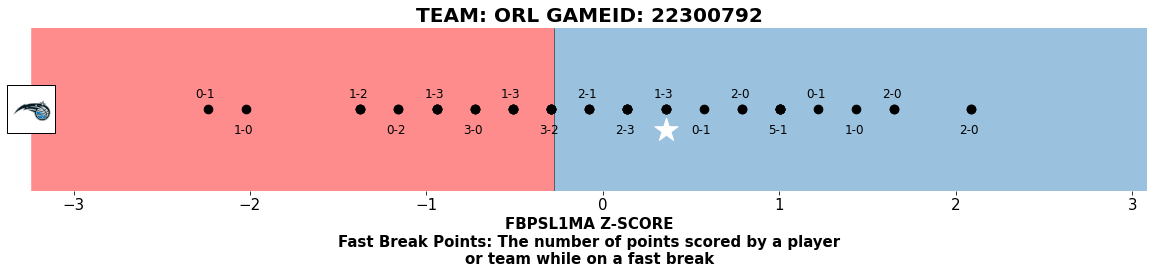

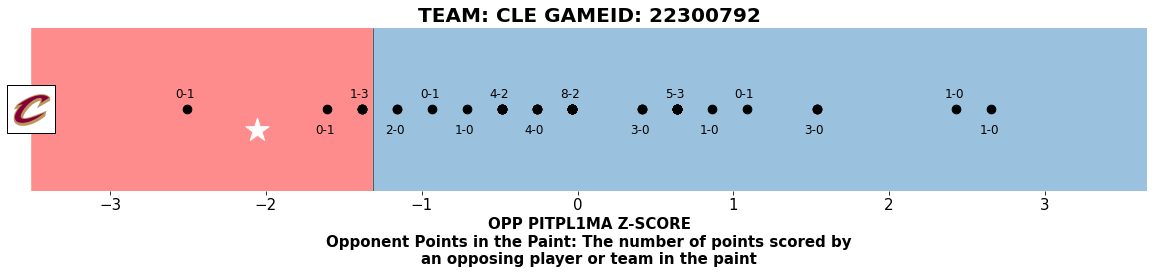

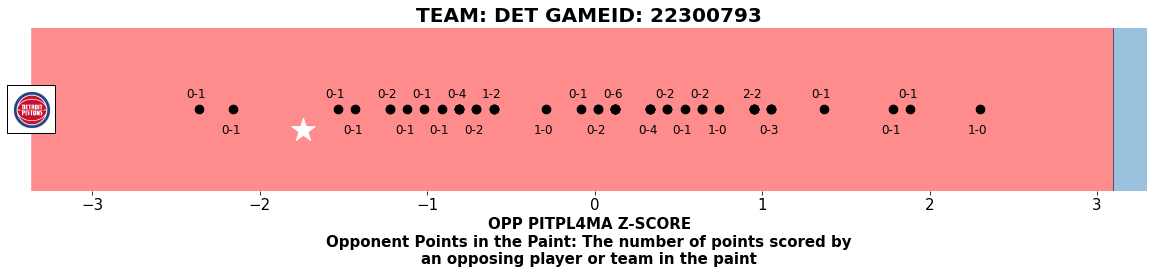

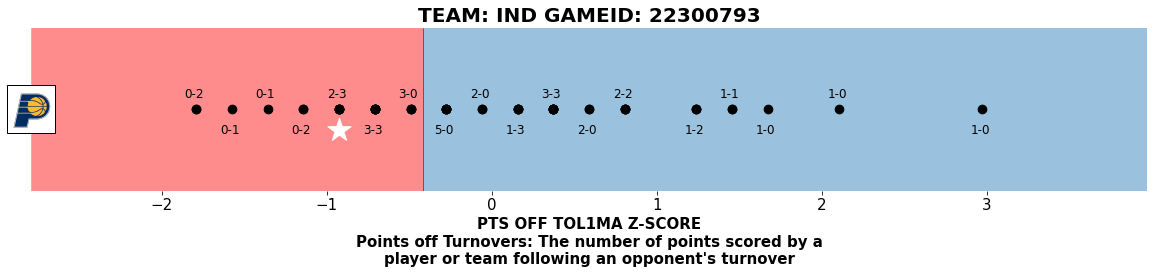

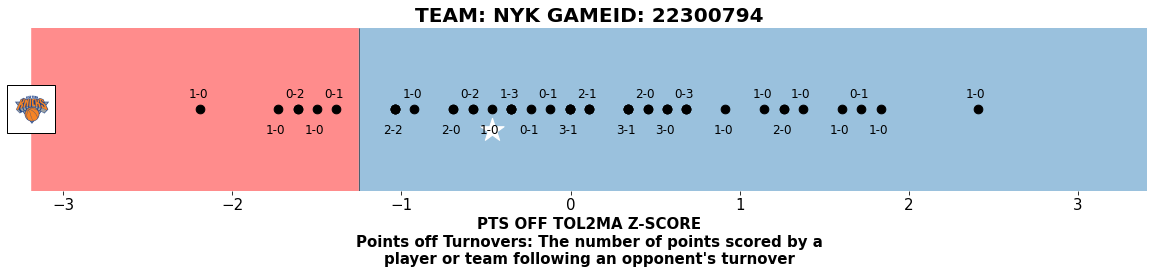

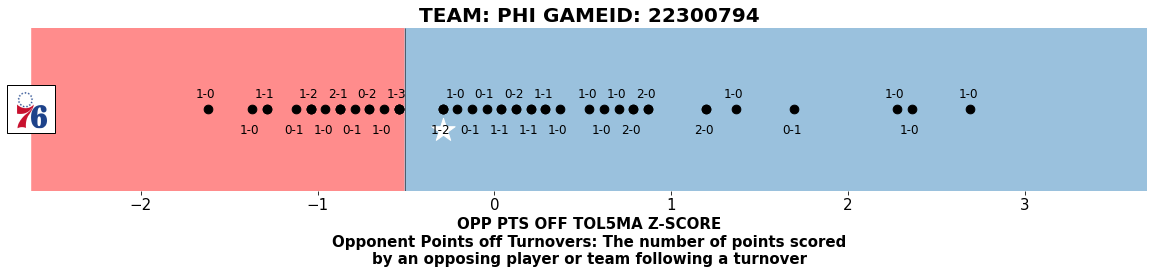

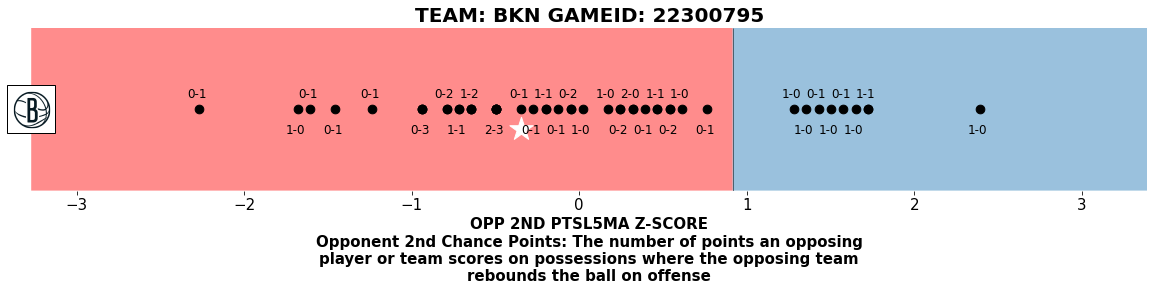

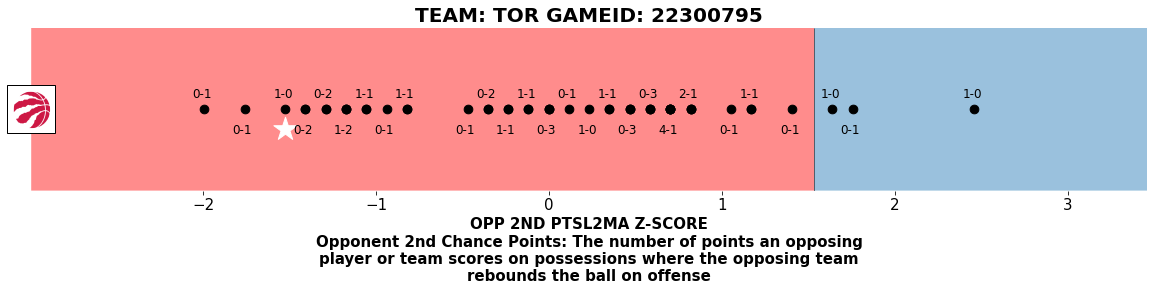

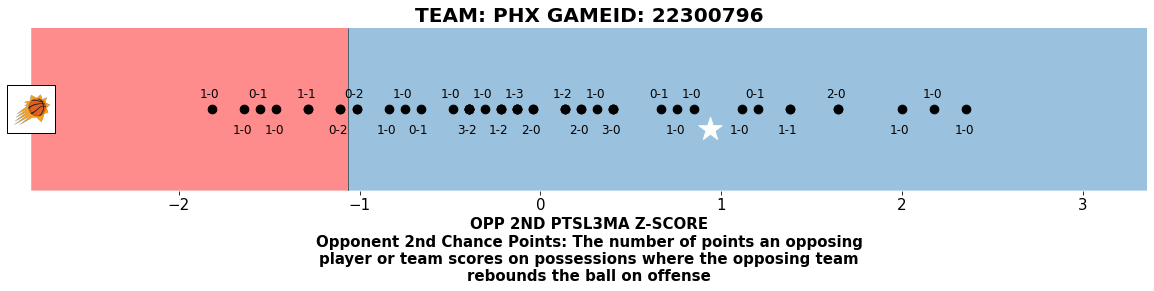

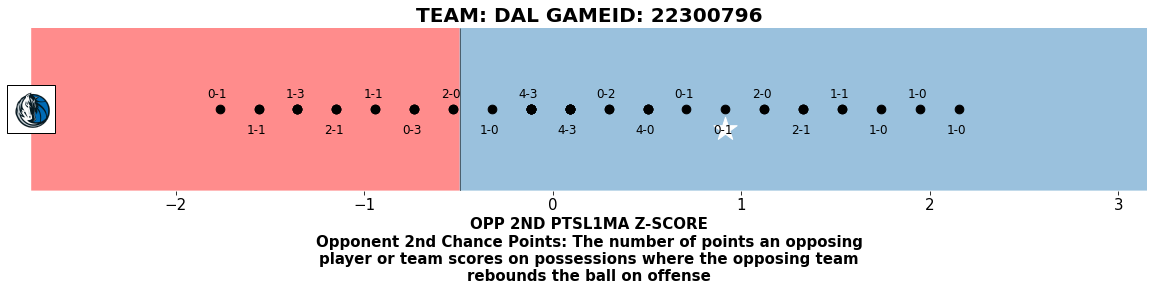

/Users/olutosinfashusi/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


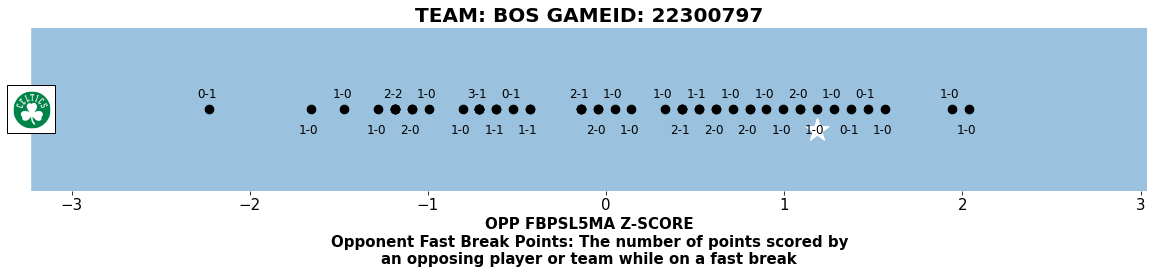

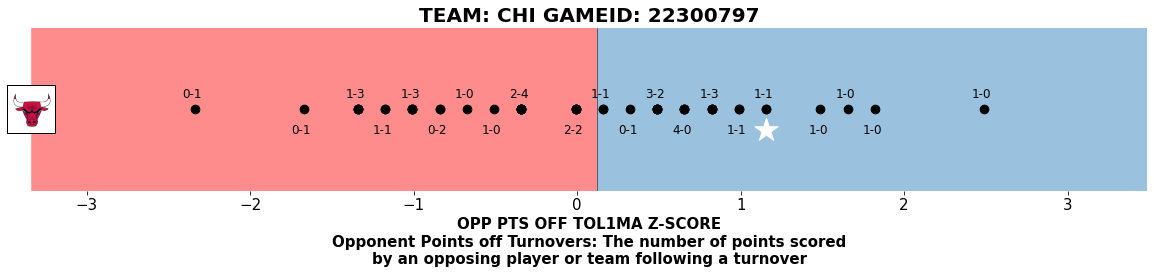

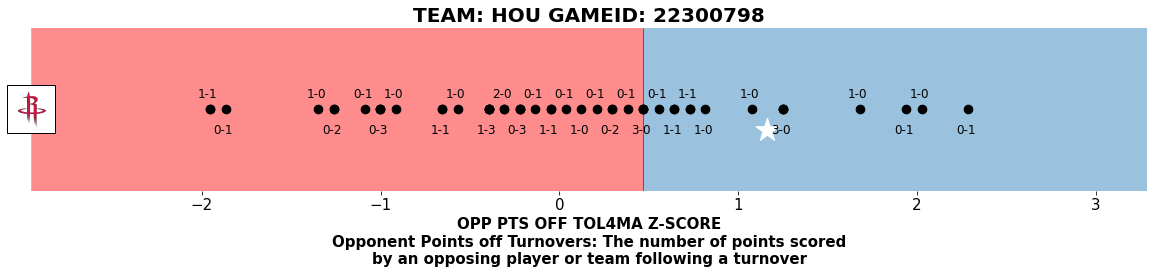

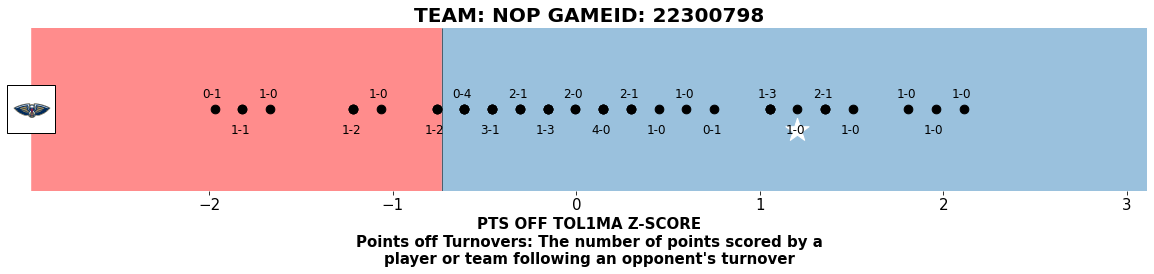

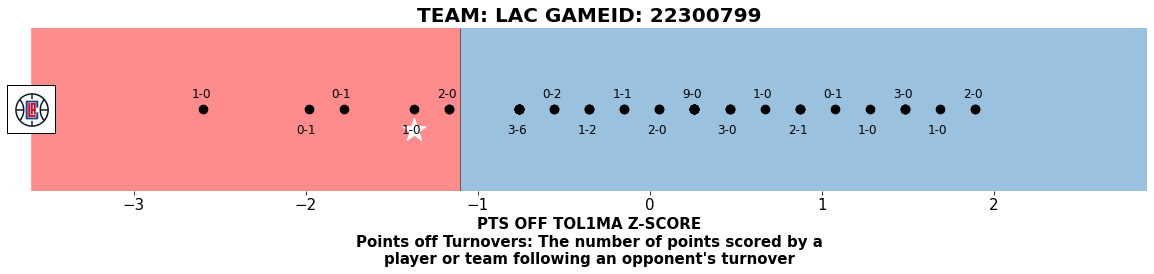

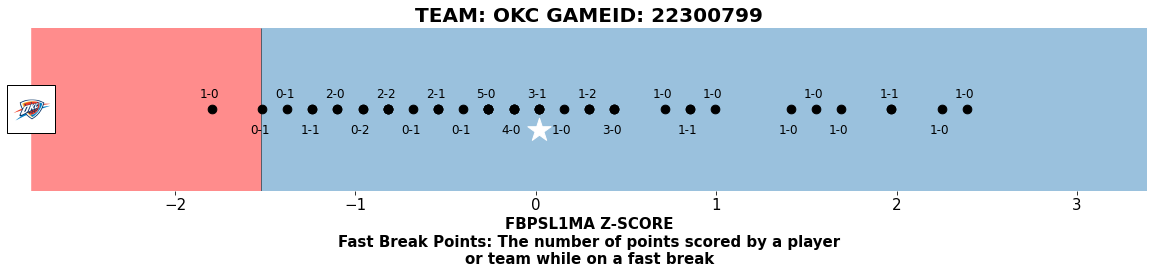

/Users/olutosinfashusi/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


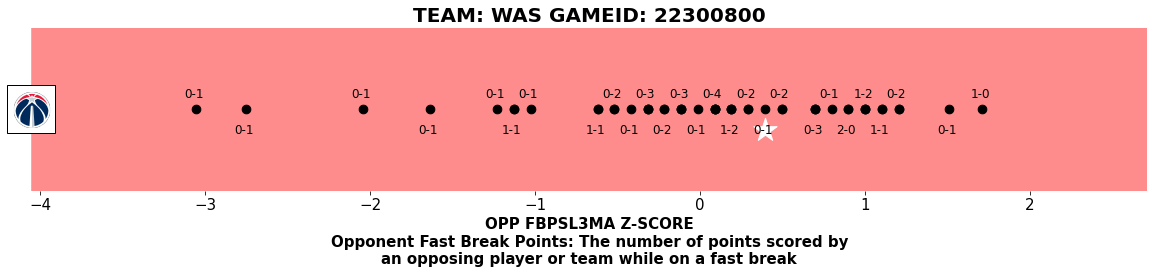

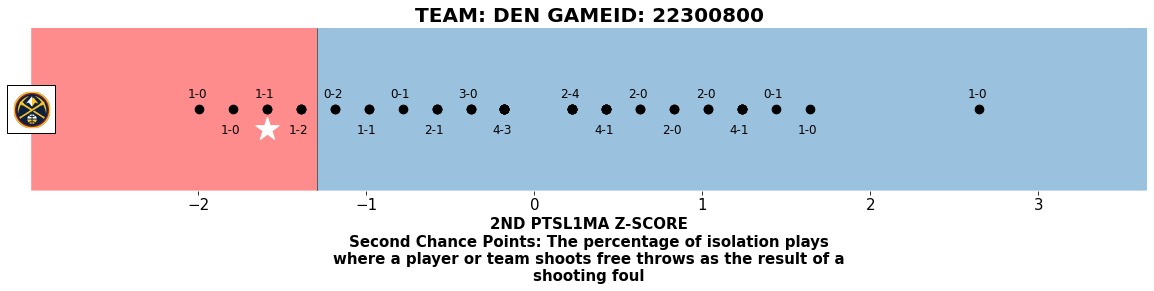

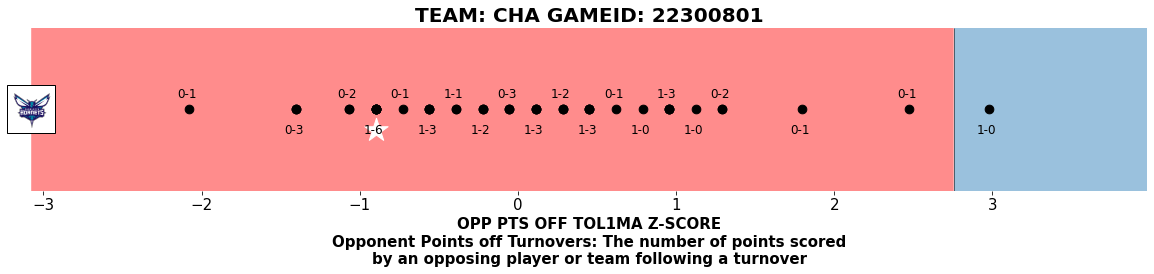

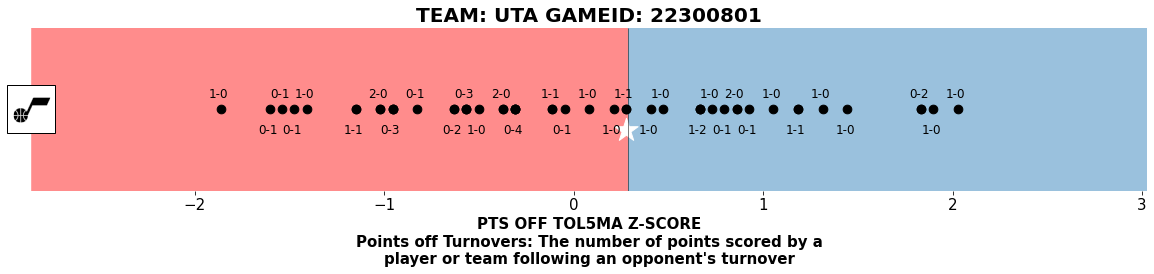

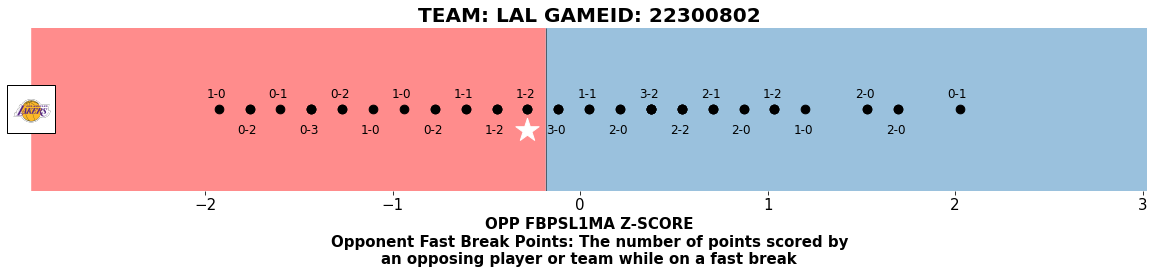

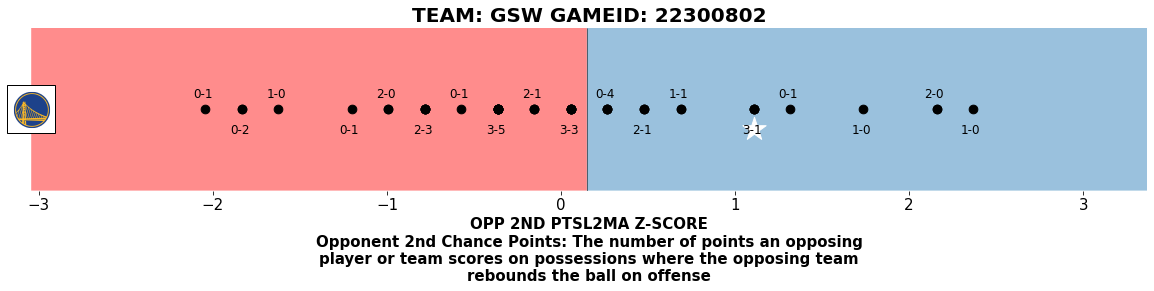

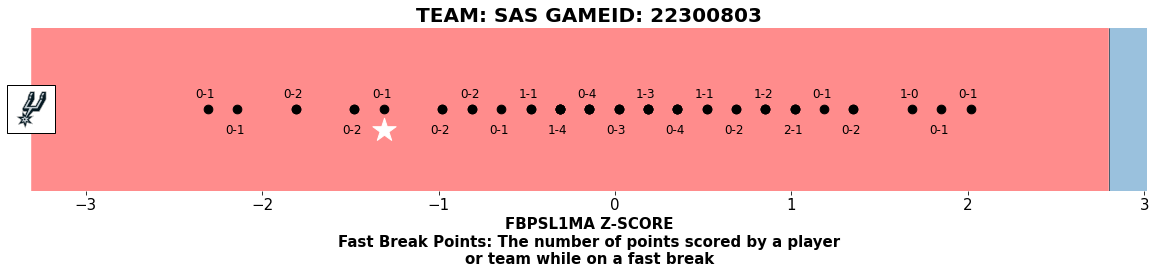

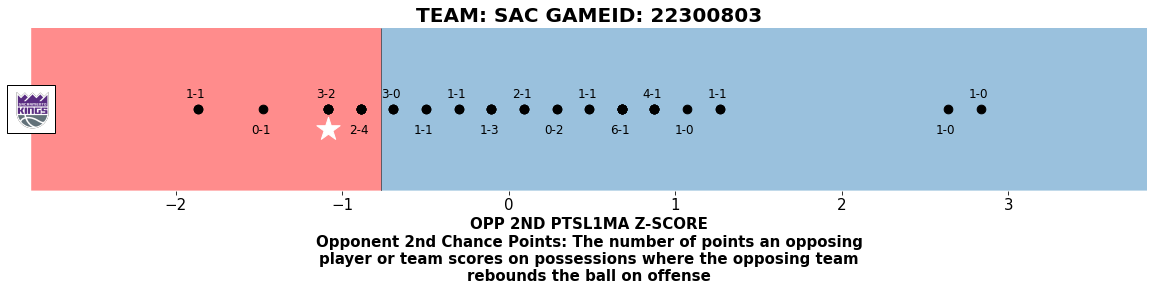

In [51]:
for team in testDetailsDF['TEAM']:
    plotStandardizedMactchPredictions(miscDF,testDetailsDF,team,datetime.date(2024,2,22),standardize=True)

In [82]:
def getTestDetailsDF(modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    return modelTypeResults[rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']
def getFeaturesByTeam(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    dateTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        dateTestDetailsDF = pd.concat([dateTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(dateTestDetailsDF [dateTestDetailsDF ['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    return leagueDF 
def featureByLeague(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    for date in datesPostAllStarGame:
        testDetailsDF = pd.concat([testDetailsDF,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(testDetailsDF[testDetailsDF['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    leagueDF = pd.DataFrame(np.unique(leagueDF['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False).reset_index(drop=True)
    return leagueDF 
def getSeasonTestDetailsDF(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    seasonTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        seasonTestDetailsDF = pd.concat([seasonTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    return seasonTestDetailsDF
def getFeatureDefintion(feature):
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return definiton
def getFeatureDefintionWrapped(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definition,60)

In [183]:
featuresByTeamDF = getFeaturesByTeam(miscDF,miscTestDetails,'standardized','oddsRatio')
featuresByTeamDF.sort_values(by=['COUNT','FEATURE'],ascending=False).reset_index(drop=True)
featuresByTeamDF
total = []
for team in featuresByTeamDF['TEAM']:
    teamDF = featuresByTeamDF[featuresByTeamDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
featuresByTeamDF['TOTAL'] = total

maxFeatureDF = pd.DataFrame()
defintions = []
string_ = []
totalEqualToCount = []
for team in NBATeams:
    teamDF = featuresByTeamDF[featuresByTeamDF['TEAM'] == team]
    maxFeatureDF = pd.concat([maxFeatureDF,
                              teamDF.head(1)],axis=0)
    defintions.append(getFeatureDefintion(teamDF['FEATURE'].values[0]))
    if teamDF['COUNT'].values[0] ==  teamDF['TOTAL'].values[0]:
        totalEqualToCount.append(team)
    string_.append(str(teamDF['COUNT'].values[0]) +'/'+str(teamDF['TOTAL'].values[0]))
maxFeatureDF = maxFeatureDF.reset_index(drop=True)
maxFeatureDF = maxFeatureDF.drop(columns=(['COUNT','TOTAL']))
maxFeatureDF['FREQUENCY'] = string_
maxFeatureDF['FEATURE DEFINTION'] =  defintions
maxFeatureDF

def highlight(row):
    rowsToHighlight = totalEqualToCount
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
maxFeatureDF.style.apply(highlight,axis=1)

,TEAM,FEATURE,FREQUENCY,FEATURE DEFINTION
0,ATL,2ND PTSL3MA,27/27,Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul
1,BKN,OPP 2ND PTSL5MA,23/28,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
2,BOS,OPP 2ND PTSL2MA,8/27,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
3,CHA,OPP PTS OFF TOL1MA,28/28,Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover
4,CHI,OPP PTS OFF TOL5MA,11/27,Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover
5,CLE,OPP PITPL1MA,27/29,Opponent Points in the Paint: The number of points scored by an opposing player or team in the paint
6,DAL,OPP 2ND PTSL1MA,21/27,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
7,DEN,OPP FBPSL4MA,24/27,Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break
8,DET,2ND PTSL2MA,9/28,Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul
9,GSW,OPP FBPSL1MA,17/29,Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break


In [184]:
feature = '2ND PTSL3MA'
results = {}
for team in NBATeams:
    results[team] = {'2ND PTSL3MA AVG IN Ws':float,'2ND PTSL3MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['2ND PTSL3MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['2ND PTSL3MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['2ND PTSL3MA AVG IN Ws'] - df['2ND PTSL3MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['ATL']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,2ND PTSL3MA AVG IN Ws,2ND PTSL3MA AVG IN Ls,∆
0,ATL,17.552381,14.750000,2.802381
1,MIL,13.645390,12.552083,1.093307
2,CLE,13.950355,12.864583,1.085771
3,POR,16.412698,15.522989,0.889710
4,SAC,14.848485,14.257143,0.591342
5,MIA,11.585185,11.078431,0.506754
6,BOS,14.655738,14.203704,0.452034
7,CHI,13.780702,13.463415,0.317287
8,MIN,13.515152,13.236111,0.279040
9,DET,13.277778,13.049751,0.228027


In [185]:
feature = 'OPP PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'OPP PTS OFF TOL1MA AVG IN Ws':float ,'OPP PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['OPP PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['OPP PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['OPP PTS OFF TOL1MA AVG IN Ws'] - df['OPP PTS OFF TOL1MA AVG IN Ls']
df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['CHA']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,OPP PTS OFF TOL1MA AVG IN Ws,OPP PTS OFF TOL1MA AVG IN Ls,∆
0,DET,22.500000,19.029851,3.470149
1,ORL,17.565217,15.114286,2.450932
2,SAS,20.363636,18.050847,2.312789
3,CHA,18.900000,16.590164,2.309836
4,GSW,18.217391,16.171429,2.045963
5,PHI,15.021277,13.382353,1.638924
6,WAS,18.000000,16.803030,1.196970
7,CHI,15.871795,14.738095,1.133700
8,MIN,16.410714,15.320000,1.090714
9,BKN,15.906250,15.122449,0.783801


In [186]:
feature = 'PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'PTS OFF TOL1MA AVG IN Ws':float ,'PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['PTS OFF TOL1MA AVG IN Ws'] - df['PTS OFF TOL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['LAC']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,PTS OFF TOL1MA AVG IN Ws,PTS OFF TOL1MA AVG IN Ls,∆
0,LAC,17.260000,14.354839,2.905161
1,ORL,19.434783,17.314286,2.120497
2,NOP,18.500000,16.454545,2.045455
3,DAL,17.224490,15.312500,1.911990
4,CHI,18.076923,16.309524,1.767399
5,PHI,18.340426,17.058824,1.281602
6,IND,18.065217,16.971429,1.093789
7,SAS,15.772727,15.118644,0.654083
8,DEN,15.732143,15.080000,0.652143
9,ATL,17.444444,16.911111,0.533333


In [187]:
feature = 'FBPSL1MA'
results = {}
for team in NBATeams:
    results[team] = {'FBPSL1MA AVG IN Ws':float ,'FBPSL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['FBPSL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['FBPSL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['FBPSL1MA AVG IN Ws'] - df['FBPSL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['OKC','MEM']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,FBPSL1MA AVG IN Ws,FBPSL1MA AVG IN Ls,∆
0,OKC,16.625000,13.920000,2.705000
1,ORL,13.282609,10.971429,2.311180
2,SAS,17.090909,14.881356,2.209553
3,MEM,12.962963,11.018519,1.944444
4,HOU,16.658537,14.825000,1.833537
5,DEN,14.589286,13.400000,1.189286
6,GSW,12.869565,11.742857,1.126708
7,CHI,12.974359,11.952381,1.021978
8,TOR,19.500000,18.508772,0.991228
9,CLE,15.170213,14.264706,0.905507


# ODDS RATIO PROFF

In [188]:
def proveFeatureSelections(NBAdf,team,features,date,standardize,sortBy):
    resultsDict = {}
    resultsDict[team] = {'DATE':[],'TEAM':[],'TRAIN SIZE':[],'FEATURE':[],'INTERCEPT':[],
                         'COEF':[],'ODDS RATIO':[],'LOG LOSS':[],'STD':[]}
    for feature in features:
        NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
        NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize): X_train = StandardScaler().fit_transform(X_train)
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        model = model.fit(X_train,y_train)
        resultsDict[team]['DATE'].append(date),
        resultsDict[team]['TEAM'].append(team)
        resultsDict[team]['TRAIN SIZE'].append(len(X_train))
        resultsDict[team]['FEATURE'].append(feature),
        resultsDict[team]['INTERCEPT'].append(model.intercept_[0])
        resultsDict[team]['COEF'].append(model.coef_[0][0])
        resultsDict[team]['ODDS RATIO'].append(np.exp(model.coef_[0][0]))
        resultsDict[team]['LOG LOSS'].append(log_loss(y_train, model.predict_proba(X_train)))
        resultsDict[team]['STD'].append(np.std(X_train))
    if sortBy == 'ODDS RATIO':
        return pd.DataFrame(resultsDict[team]).sort_values(by='ODDS RATIO',ascending=False).reset_index(drop=True)
    if sortBy == 'LOG LOSS':
        return pd.DataFrame(resultsDict[team]).sort_values(by='LOG LOSS',ascending=True).reset_index(drop=True)

In [189]:
ORL_byOddsRatioTrue = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=False,sortBy='ODDS RATIO')
ORL_byOddsRatioStandardized = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=True,sortBy='ODDS RATIO')
ORL_byLogLossTrue = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=False,sortBy='LOG LOSS')
ORL_byLogLossStandardized = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=True,sortBy='LOG LOSS')

In [190]:
def highlight(row):
    rowsToHighlight  = list(ORL_byOddsRatioTrue.head().index.values) + list(ORL_byOddsRatioTrue.tail().index.values)
    if row.name in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
ORL_byOddsRatioTrue.style.apply(highlight,axis=1)

,DATE,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,STD
0,2024-02-22,ORL,50,FBPSL1MA,-1.877551,0.154112,1.166621,0.635021,4.624976
1,2024-02-22,ORL,50,PTS OFF TOL5MA,-2.643336,0.149497,1.161250,0.677058,2.143362
2,2024-02-22,ORL,50,PTS OFF TOL3MA,-1.676576,0.098302,1.103296,0.676977,3.310831
3,2024-02-22,ORL,50,OPP FBPSL5MA,-1.082496,0.087586,1.091536,0.680087,3.225402
4,2024-02-22,ORL,50,PTS OFF TOL2MA,-1.306061,0.078917,1.082115,0.675812,4.311392
5,2024-02-22,ORL,50,FBPSL5MA,-0.811459,0.072609,1.075310,0.687203,2.011364
6,2024-02-22,ORL,50,FBPSL4MA,-0.804980,0.071949,1.074601,0.686739,2.201727
7,2024-02-22,ORL,50,OPP PTS OFF TOL1MA,-0.959280,0.068191,1.070569,0.667515,6.391275
8,2024-02-22,ORL,50,OPP FBPSL2MA,-0.686521,0.059335,1.061131,0.679132,5.023385
9,2024-02-22,ORL,50,OPP PTS OFF TOL2MA,-0.791878,0.057469,1.059152,0.681903,4.453414


In [191]:
ORL_byOddsRatioStandardized
def highlight(row):
    rowsToHighlight  = list(ORL_byOddsRatioStandardized.head().index.values) + list(ORL_byOddsRatioStandardized.tail().index.values)
    if row.name in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
ORL_byOddsRatioStandardized.style.apply(highlight,axis=1)

,DATE,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,STD
0,2024-02-22,ORL,50,FBPSL1MA,0.177765,0.648151,1.912002,0.635458,1.000000
1,2024-02-22,ORL,50,OPP PTS OFF TOL1MA,0.167306,0.401100,1.493466,0.667657,1.000000
2,2024-02-22,ORL,50,PTS OFF TOL2MA,0.163675,0.315113,1.370414,0.675896,1.000000
3,2024-02-22,ORL,50,PTS OFF TOL3MA,0.163247,0.302232,1.352875,0.677054,1.000000
4,2024-02-22,ORL,50,PTS OFF TOL5MA,0.163781,0.300912,1.351090,0.677131,1.000000
5,2024-02-22,ORL,50,PITPL1MA,0.163250,0.288498,1.334422,0.678184,1.000000
6,2024-02-22,ORL,50,OPP FBPSL2MA,0.163745,0.275756,1.317526,0.679196,1.000000
7,2024-02-22,ORL,50,OPP FBPSL5MA,0.163222,0.262774,1.300532,0.680144,1.000000
8,2024-02-22,ORL,50,OPP FBPSL1MA,0.163769,0.262657,1.300380,0.680250,1.000000
9,2024-02-22,ORL,50,OPP PITPL1MA,0.162885,0.254054,1.289241,0.680768,1.000000


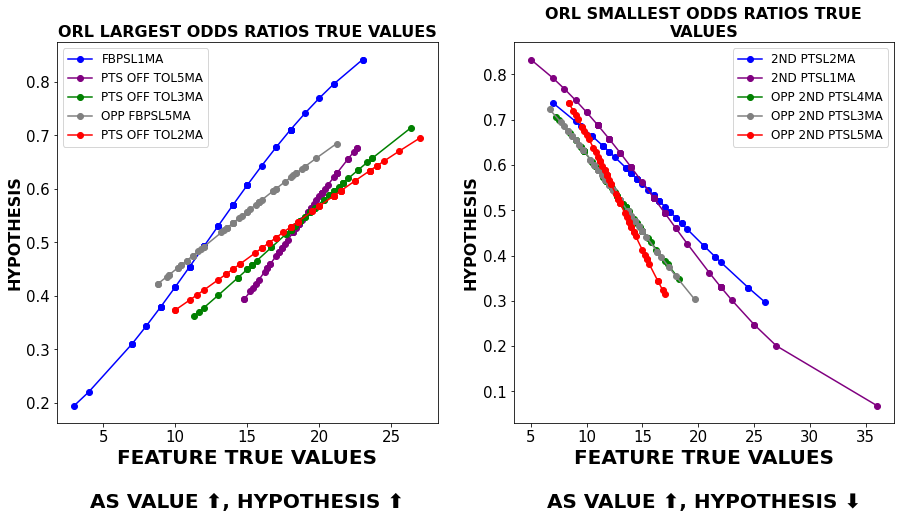

In [192]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
largestOddsRatioFeatures = ORL_byOddsRatioTrue.head()['FEATURE'].values
for feature in largestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(largestOddsRatioFeatures).index(feature)],label=feature,marker='o');
ax0.tick_params(labelsize=15)
titleText = 'ORL LARGEST ODDS RATIOS TRUE VALUES'
titleText = textwrap.fill(titleText,35)
ax0.set_title(titleText,size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');

xLabelText = 'AS VALUE ⬆️, HYPOTHESIS ⬆️'
xLabelText = textwrap.fill(xLabelText,35)
ax0.set_xlabel('FEATURE TRUE VALUES'+'\n\n'+xLabelText,size=20,fontweight ='bold');
ax0.legend(loc="upper left",prop={'size':12})

smallestOddsRatioFeatures = ORL_byOddsRatioTrue.tail()['FEATURE'].values
for feature in smallestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(smallestOddsRatioFeatures).index(feature)],marker='o',label=feature);
ax1.tick_params(labelsize=15)
titleText = 'ORL SMALLEST ODDS RATIOS TRUE VALUES'
titleText = textwrap.fill(titleText,35)
ax1.set_title(titleText,size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');

xLabelText = 'AS VALUE ⬆️, HYPOTHESIS ⬇️'
xLabelText = textwrap.fill(xLabelText,35)
ax1.set_xlabel('FEATURE TRUE VALUES'+'\n\n'+xLabelText,size=20,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})

plt.show()

# STANDARDIZED FEATURE VALUES

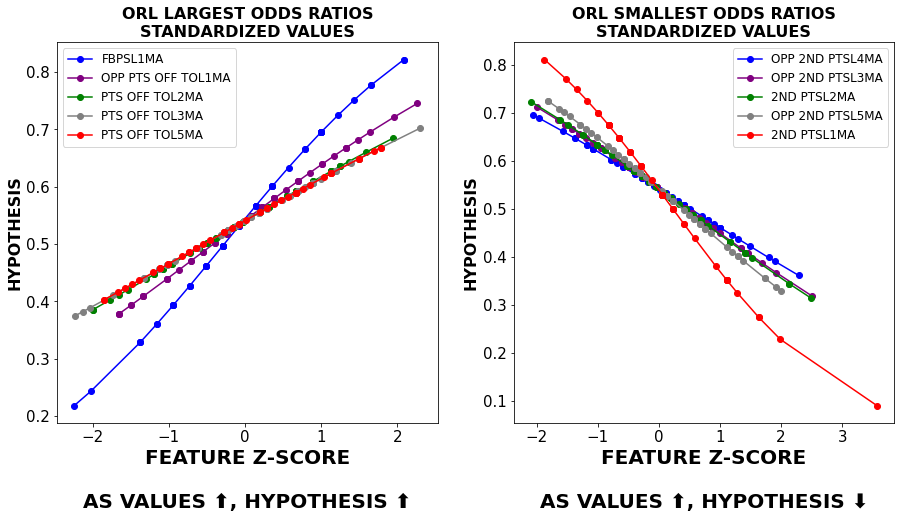

In [193]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
largestOddsRatioFeatures = ORL_byOddsRatioStandardized.head()['FEATURE'].values
for feature in largestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(largestOddsRatioFeatures).index(feature)],label=feature,marker='o');
ax0.tick_params(labelsize=15)
titleText = 'ORL LARGEST ODDS RATIOS STANDARDIZED VALUES'
titleText = textwrap.fill(titleText,35)
ax0.set_title(titleText,size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.legend(loc="upper left",prop={'size':12})

xLabelText = 'AS VALUES ⬆️, HYPOTHESIS ⬆️'
xLabelText = textwrap.fill(xLabelText,35)
ax0.set_xlabel('FEATURE Z-SCORE'+'\n\n'+xLabelText,size=20,fontweight ='bold');

smallestOddsRatioFeatures = ORL_byOddsRatioStandardized.tail()['FEATURE'].values
for feature in smallestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(smallestOddsRatioFeatures).index(feature)],marker='o',label=feature);
    
ax1.tick_params(labelsize=15)
titleText = 'ORL SMALLEST ODDS RATIOS STANDARDIZED VALUES'
titleText = textwrap.fill(titleText,35)
ax1.set_title(titleText,size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})

xLabelText = 'AS VALUES ⬆️, HYPOTHESIS ⬇️'
xLabelText = textwrap.fill(xLabelText,35)
ax1.set_xlabel('FEATURE Z-SCORE'+'\n\n'+xLabelText,size=20,fontweight ='bold');

plt.show()

In [194]:
def highlight(row):
    rowsToHighlight  = list(ORL_byLogLossTrue.head().index.values) + list(ORL_byLogLossTrue.tail().index.values)
    if row.name in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
ORL_byLogLossTrue.style.apply(highlight,axis=1)

,DATE,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,STD
0,2024-02-22,ORL,50,2ND PTSL1MA,2.283301,-0.135776,0.873038,0.630259,5.697157
1,2024-02-22,ORL,50,FBPSL1MA,-1.877551,0.154112,1.166621,0.635021,4.624976
2,2024-02-22,ORL,50,OPP 2ND PTSL5MA,2.788326,-0.209739,0.810796,0.663004,2.248986
3,2024-02-22,ORL,50,OPP PTS OFF TOL1MA,-0.959280,0.068191,1.070569,0.667515,6.391275
4,2024-02-22,ORL,50,2ND PTSL2MA,1.724048,-0.099528,0.905265,0.669697,4.135952
5,2024-02-22,ORL,50,OPP 2ND PTSL3MA,1.877989,-0.137717,0.871345,0.670717,2.892327
6,2024-02-22,ORL,50,OPP 2ND PTSL4MA,1.865156,-0.136354,0.872534,0.675349,2.525193
7,2024-02-22,ORL,50,PTS OFF TOL2MA,-1.306061,0.078917,1.082115,0.675812,4.311392
8,2024-02-22,ORL,50,PTS OFF TOL3MA,-1.676576,0.098302,1.103296,0.676977,3.310831
9,2024-02-22,ORL,50,PTS OFF TOL5MA,-2.643336,0.149497,1.161250,0.677058,2.143362


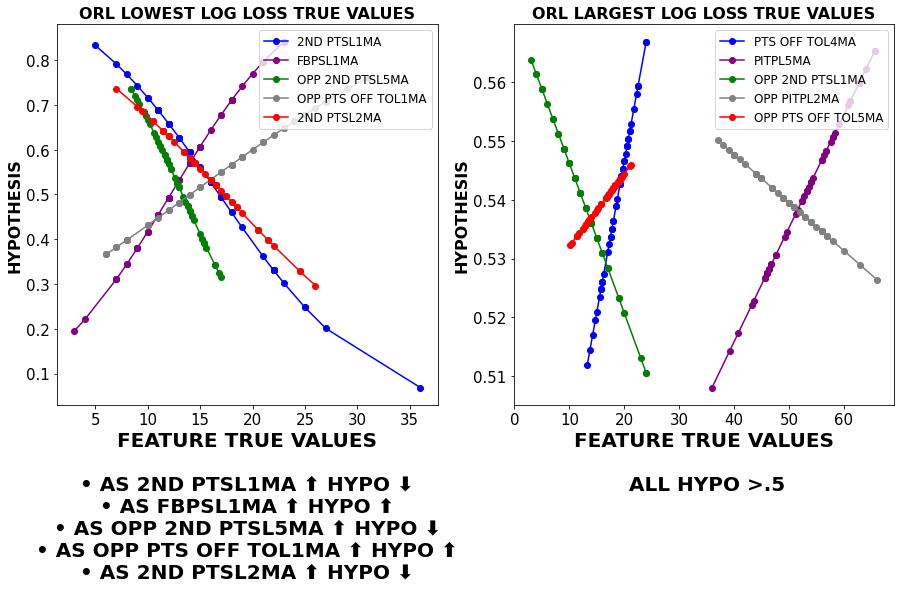

In [195]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
lowestLogLossFeatures = ORL_byLogLossTrue.head()['FEATURE'].values
for feature in lowestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(lowestLogLossFeatures).index(feature)],label=feature,marker='o');
ax0.tick_params(labelsize=15)
titleText = 'ORL LOWEST LOG LOSS TRUE VALUES'
titleText = textwrap.fill(titleText,35)
ax0.set_title(titleText,size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.set_xlabel('FEATURE TRUE VALUES\n\n'
               '• AS '+lowestLogLossFeatures[0]+' ⬆️ HYPO ⬇️\n'
               '• AS '+lowestLogLossFeatures[1]+' ⬆️ HYPO ⬆️\n'
               '• AS '+lowestLogLossFeatures[2]+' ⬆️ HYPO ⬇️\n'
               '• AS '+lowestLogLossFeatures[3]+' ⬆️ HYPO ⬆️\n'
               '• AS '+lowestLogLossFeatures[4]+' ⬆️ HYPO ⬇️\n'
               ,size=20,fontweight ='bold');
ax0.legend(loc="upper right",prop={'size':12})

largestLogLossFeatures = ORL_byLogLossTrue.tail()['FEATURE'].values
for feature in largestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(largestLogLossFeatures).index(feature)],label=feature,marker='o');
ax1.tick_params(labelsize=15)
titleText = 'ORL LARGEST LOG LOSS TRUE VALUES'
titleText = textwrap.fill(titleText,35)
ax1.set_title(titleText,size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.set_xlabel('FEATURE TRUE VALUES\n\n ALL HYPO >.5',size=20,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})
plt.show()

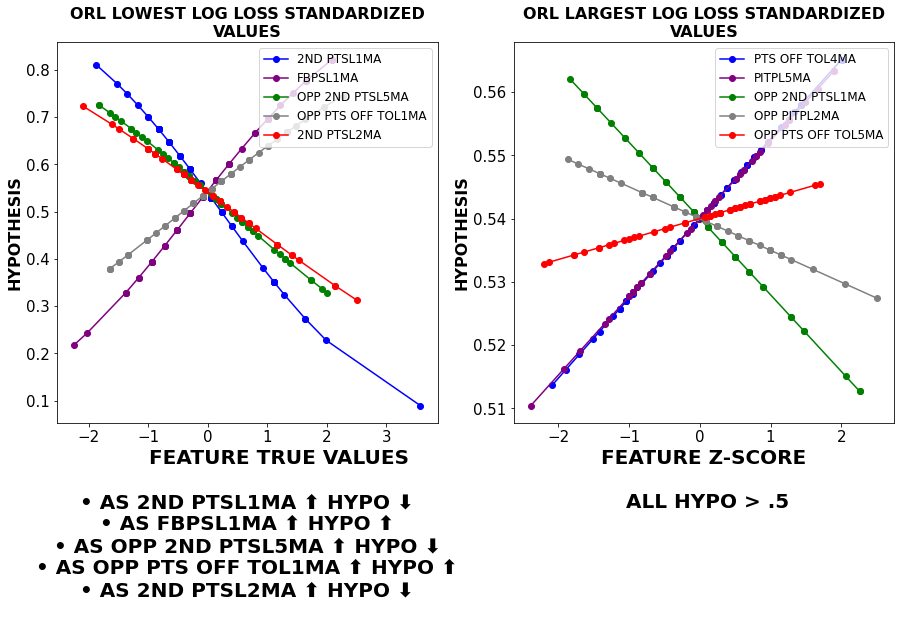

In [199]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
lowestLogLossFeatures = ORL_byLogLossStandardized.head()['FEATURE'].values
for feature in lowestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(lowestLogLossFeatures).index(feature)],label=feature,marker='o');
ax0.tick_params(labelsize=15)
titleText = 'ORL LOWEST LOG LOSS STANDARDIZED VALUES'
titleText = textwrap.fill(titleText,35)
ax0.set_title(titleText,size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.set_xlabel('         FEATURE TRUE VALUES\n\n'
               '• AS '+lowestLogLossFeatures[0]+' ⬆️ HYPO ⬇️\n'
               '• AS '+lowestLogLossFeatures[1]+' ⬆️ HYPO ⬆️\n'
               '• AS '+lowestLogLossFeatures[2]+' ⬆️ HYPO ⬇️\n'
               '• AS '+lowestLogLossFeatures[3]+' ⬆️ HYPO ⬆️\n'
               '• AS '+lowestLogLossFeatures[4]+' ⬆️ HYPO ⬇️\n'
               ,size=20,fontweight ='bold');
ax0.legend(loc="upper right",prop={'size':12})

largestLogLossFeatures = ORL_byLogLossStandardized.tail()['FEATURE'].values
for feature in largestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(largestLogLossFeatures).index(feature)],label=feature,marker='o');
ax1.tick_params(labelsize=15)
titleText = 'ORL LARGEST LOG LOSS STANDARDIZED VALUES'
titleText = textwrap.fill(titleText,35)
ax1.set_title(titleText,size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.set_xlabel('FEATURE Z-SCORE\n\n ALL HYPO > .5',size=20,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})
plt.show()

In [202]:
def getActualWinnerAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBATeams): predictionsByTeam[team] = {}
    for team in np.unique(NBATeams):
        predictionsByTeam[team]['✅'] = int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
        predictionsByTeam[team]['❌'] = len(predictionsDF[predictionsDF['MODEL PREDICTS'] == team]) - int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS ACTUAL%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF
def getBettingFavoriteAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBATeams): predictionsByTeam[team] = {'✅':0,'❌':0}
    for i in range (len(predictionsDF)):
        if predictionsDF.iloc[i]['MODEL PREDICTS'] != ' ':
            if predictionsDF.iloc[i]['MODEL PREDICTS'] == predictionsDF.iloc[i]['BETTING FAVORITE'][0]:
                predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅']+1
            else: predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌']+1
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS BETTING FAVORITE%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF

In [203]:
actualWinnerAccuracyByTeam = getActualWinnerAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))
bettingFavoriteAccuracyByTeam = getBettingFavoriteAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))

In [204]:
pd.concat([actualWinnerAccuracyByTeam,
          bettingFavoriteAccuracyByTeam],axis=1) 

,✅,❌,MODEL VS ACTUAL%,✅,❌,MODEL VS BETTING FAVORITE%
ATL,6,6,0.500000,9,3,0.750000
BKN,5,5,0.500000,6,4,0.600000
BOS,21,6,0.777778,26,1,0.962963
CHA,1,2,0.333333,0,3,0.000000
CHI,5,8,0.384615,6,7,0.461538
CLE,9,12,0.428571,15,6,0.714286
DAL,10,5,0.666667,13,2,0.866667
DEN,15,4,0.789474,18,1,0.947368
DET,0,0,NaN,0,0,NaN
GSW,14,3,0.823529,15,2,0.882353


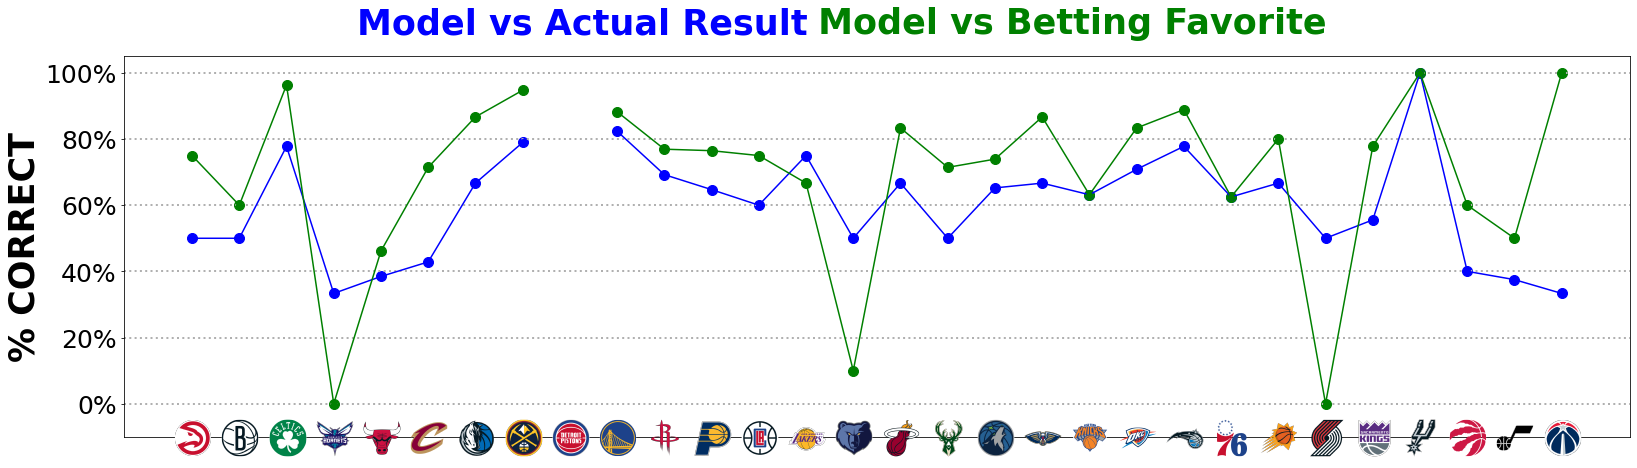

In [205]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymin = ymin - .1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymax = ymax + .05
ax.set_ylim(ymin,ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))  

plt.ylabel('% CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

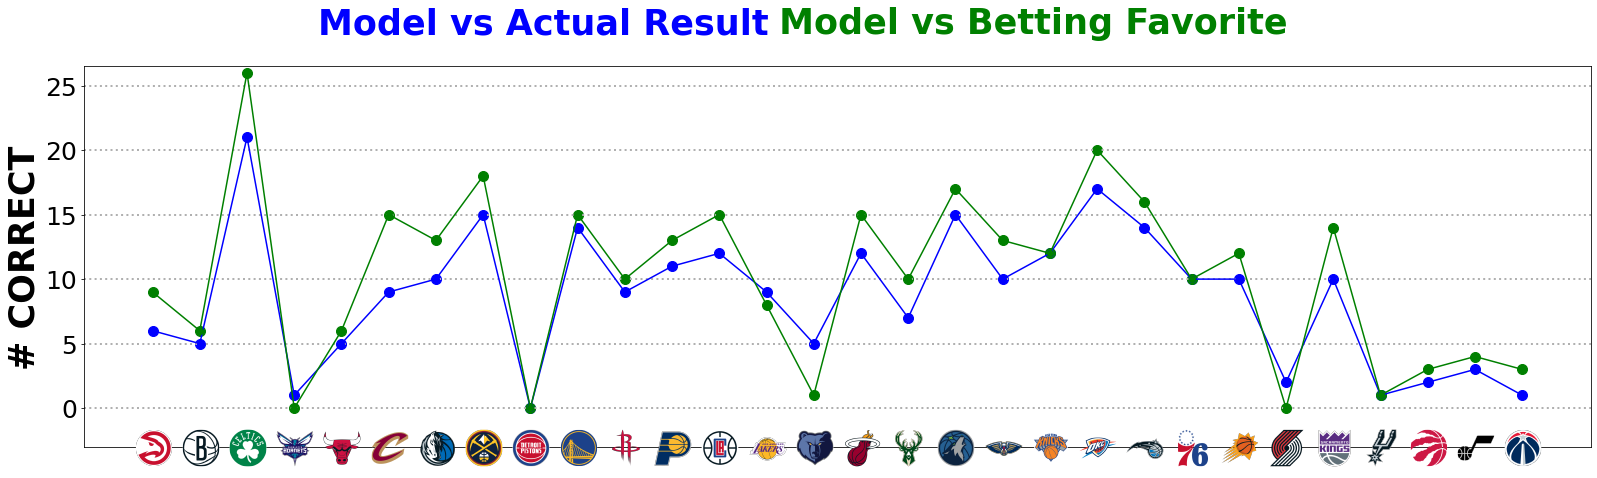

In [206]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymin = ymin - 3
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)

plt.ylabel('# CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

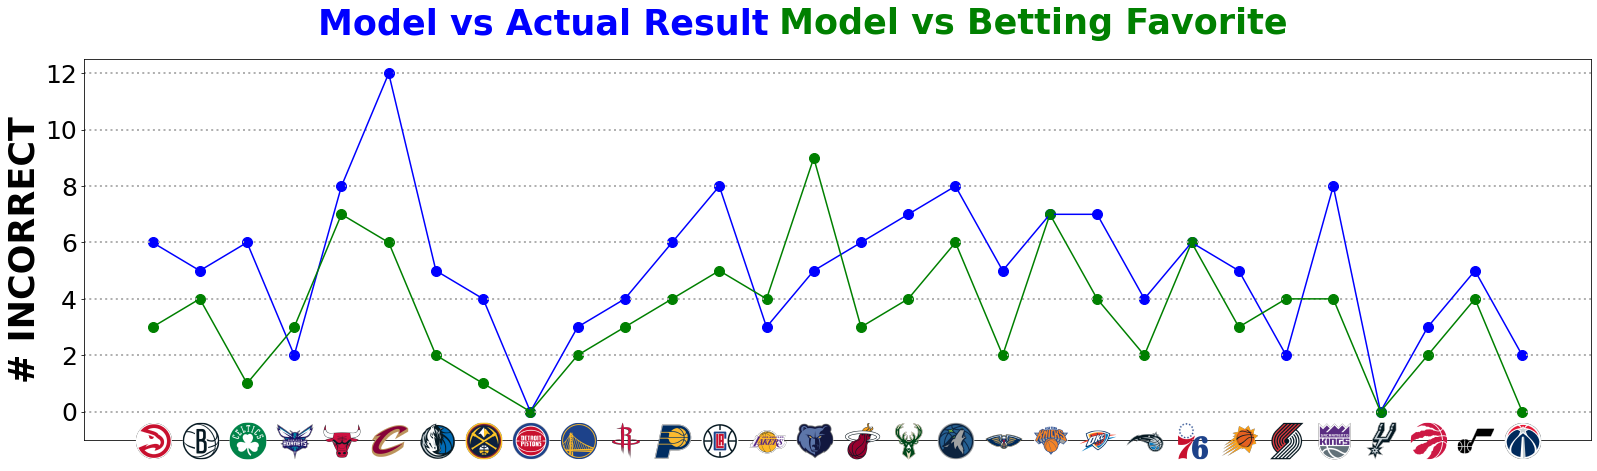

In [207]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymin = ymin - 1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)

plt.ylabel('# INCORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)

ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')

plt.grid(linestyle=':',linewidth=2)
plt.show()

# FURTHER QUESTIONS

# TEAM WIN% AT HOME?

In [208]:
feature = 'H/A'
teamDF = traditionalDF[traditionalDF['TEAM'] == team]
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] == 1]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] == 1]['RESULT'] == 0)
    results[team]['GP'] = results[team]['W'] + results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,BOS,37,4,41,90.2%
1,DEN,33,8,41,80.5%
2,OKC,33,8,41,80.5%
3,MIL,31,11,42,73.8%
4,MIN,30,11,41,73.2%
5,ORL,29,12,41,70.7%
6,LAL,28,14,42,66.7%
7,NYK,27,14,41,65.9%
8,HOU,27,14,41,65.9%
9,CLE,26,15,41,63.4%


# TEAM WIN% ON THE ROAD?

In [209]:
feature = 'H/A'
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] == 0]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] == 0]['RESULT'] == 0)
    results[team]['GP'] =  results[team]['W'] +  results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,NOP,28,14,42,66.7%
1,BOS,27,14,41,65.9%
2,MIN,26,15,41,63.4%
3,LAC,26,15,41,63.4%
4,DAL,25,16,41,61.0%
5,GSW,25,16,41,61.0%
6,MIA,24,17,41,58.5%
7,OKC,24,17,41,58.5%
8,DEN,24,17,41,58.5%
9,PHX,24,17,41,58.5%


# TEAM WIN% WITH 0 DAYS OFF

In [210]:
feature = 'DAYSOFF'
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] == 0]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] == 0]['RESULT'] == 0)
    results[team]['GP'] =  results[team]['W'] +  results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,BOS,12,2,14,85.7%
1,PHX,10,4,14,71.4%
2,MIL,10,4,14,71.4%
3,DEN,9,4,13,69.2%
4,DAL,9,5,14,64.3%
5,MIN,8,5,13,61.5%
6,GSW,10,7,17,58.8%
7,POR,8,6,14,57.1%
8,OKC,8,6,14,57.1%
9,NOP,7,6,13,53.8%


# TEAM WIN% WITH 1 DAY OFF

In [211]:
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] == 1]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] == 1]['RESULT'] == 0)
    results[team]['GP'] =  results[team]['W'] +  results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,OKC,38,14,52,73.1%
1,BOS,36,14,50,72.0%
2,DEN,37,15,52,71.2%
3,ORL,35,15,50,70.0%
4,CLE,34,16,50,68.0%
5,MIN,36,17,53,67.9%
6,LAL,31,18,49,63.3%
7,NYK,33,20,53,62.3%
8,IND,33,20,53,62.3%
9,LAC,31,20,51,60.8%


# TEAM WIN% WITH 2 DAYS OFF

In [212]:
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] == 2]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] == 2]['RESULT'] == 0)
    results[team]['GP'] =  results[team]['W'] +  results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,LAC,10,1,11,90.9%
1,BOS,12,2,14,85.7%
2,MIN,9,2,11,81.8%
3,MIA,9,3,12,75.0%
4,OKC,8,3,11,72.7%
5,NYK,8,3,11,72.7%
6,PHI,7,3,10,70.0%
7,GSW,7,3,10,70.0%
8,MIL,10,5,15,66.7%
9,DEN,8,4,12,66.7%


# TEAM WIN% WITH >2 DAYS OFF

In [213]:
results = {}
for team in NBATeams:
    results[team] = {'W':int,'L':int,'GP':int}
for team in NBATeams:
    teamDF = traditionalDF[traditionalDF['TEAM'] == team]
    results[team]['W'] = sum(teamDF[teamDF[feature] > 2]['RESULT'] == 1)
    results[team]['L'] = sum(teamDF[teamDF[feature] > 2]['RESULT'] == 0)
    results[team]['GP'] =  results[team]['W'] +  results[team]['L']
df = pd.DataFrame(results).T
fStrings = []
for i in range(len(df)):
    if df.iloc[i]['W']+df.iloc[i]['L'] > 0:
        value = df.iloc[i]['W']/(df.iloc[i]['W']+df.iloc[i]['L'])
        fString =  f'{value:.1%}'
        fStrings.append(fString)
    else: fStrings.append(np.nan)
df['tempW%'] = round((df['W']/(df['W']+ df['L'])) * 100,1)
df['W%'] = fStrings
df = df.sort_values(by='tempW%',ascending=False)
df = df.drop(columns='tempW%')
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df

,TEAM,W,L,GP,W%
0,SAC,4,0,4,100.0%
1,BOS,3,0,3,100.0%
2,NOP,4,0,4,100.0%
3,MIL,2,0,2,100.0%
4,CLE,4,1,5,80.0%
5,CHI,3,1,4,75.0%
6,DAL,3,1,4,75.0%
7,NYK,3,1,4,75.0%
8,MIN,3,1,4,75.0%
9,MEM,2,1,3,66.7%
